# Code 9: End to End Bayesian Workflows

```{admonition} This is a reference notebook for the book Bayesian Modeling and Computation in Python
:class: tip, dropdown
The textbook is not needed to use or run this code, though the context and explanation is missing from this notebook.

If you'd like a copy it's available
[from the CRC Press](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368)
or from [Amazon](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368).
``

In [1]:
import pandas as pd
import arviz as az

import matplotlib.pyplot as plt
import pymc as pm
import numpy as np


np.random.seed(seed=233423)
sampling_random_seed = 0

In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300 

## Making a Model and Probably More Than One

### Code 9.1 and Figure 9.2

In [3]:
df = pd.read_csv("../data/948363589_T_ONTIME_MARKETING.zip", low_memory=False)

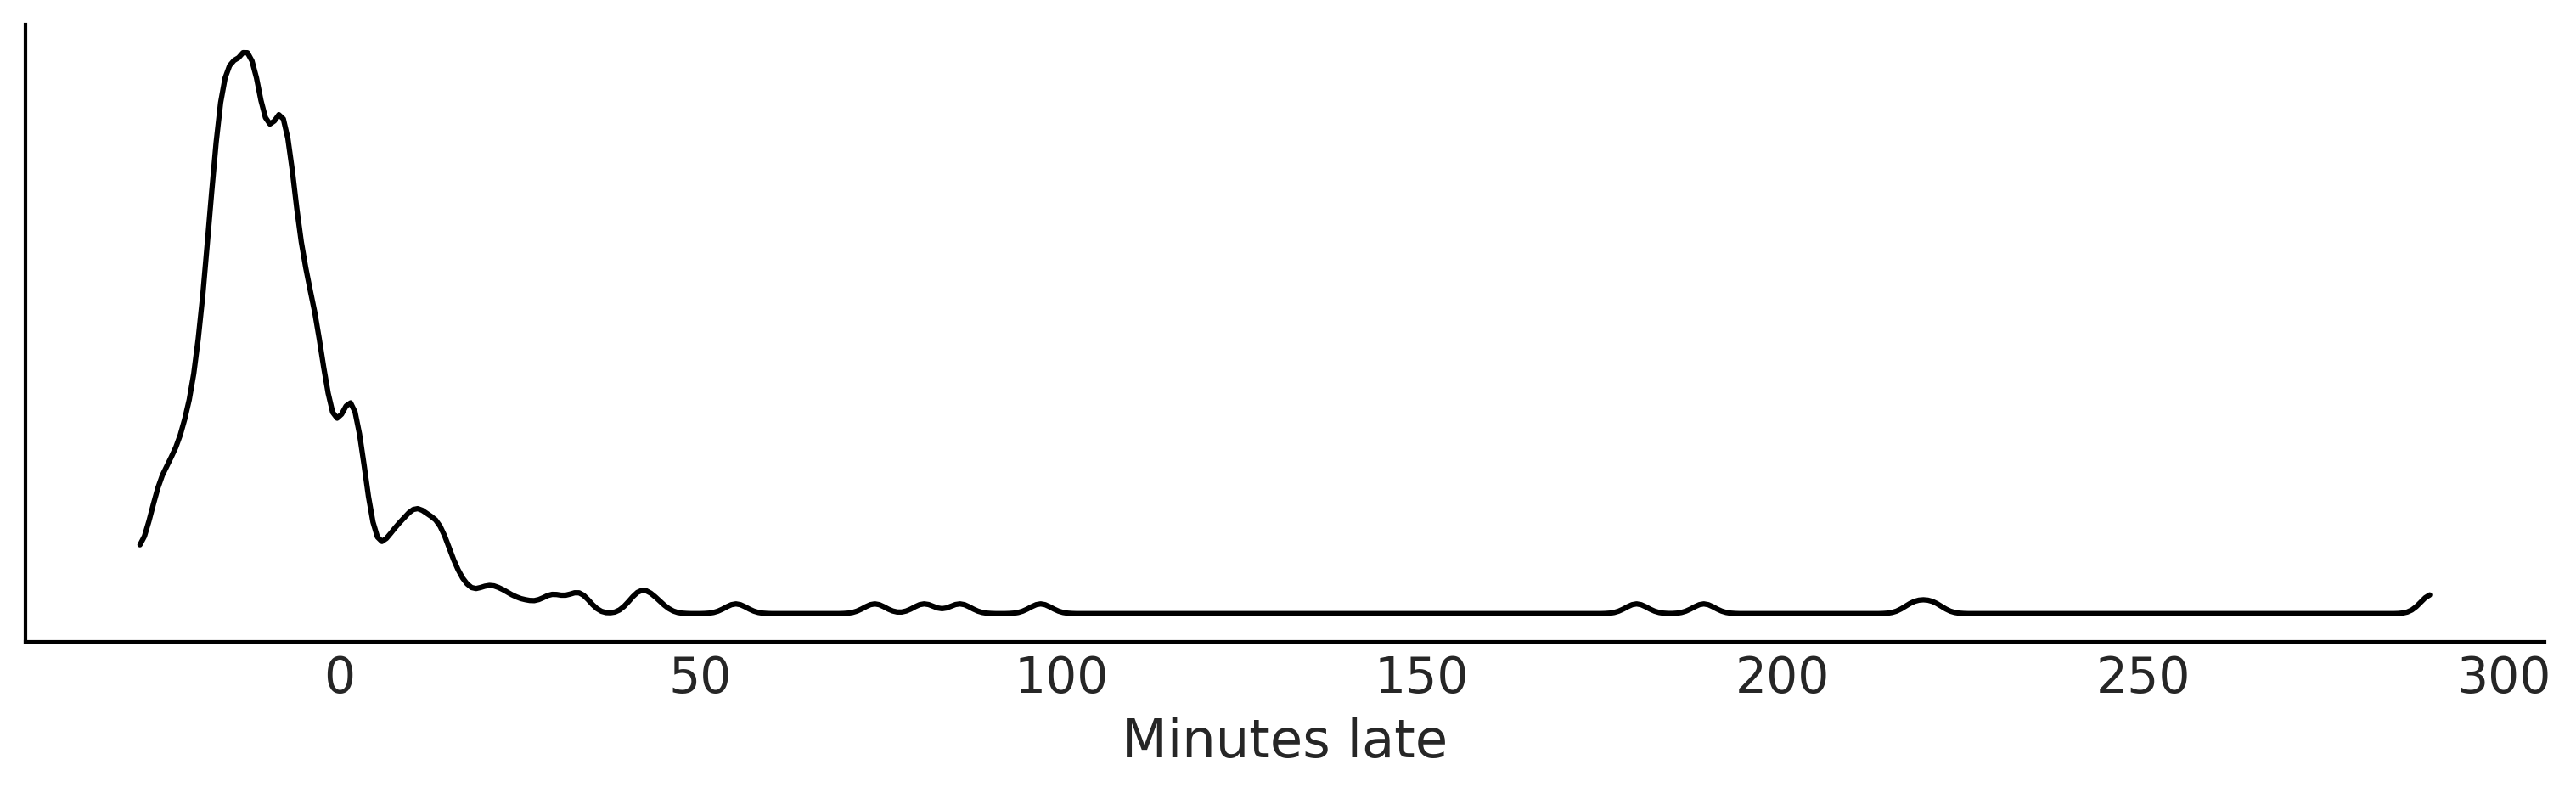

In [4]:
fig, ax = plt.subplots(figsize=(10, 3))
msn_arrivals = df[(df["DEST"] == 'MSN') & df["ORIGIN"]
                  .isin(["MSP", "DTW"])]["ARR_DELAY"]

az.plot_kde(msn_arrivals.values, ax=ax)
ax.set_yticks([])
ax.set_xlabel("Minutes late")
plt.savefig('img/chp09/arrivaldistributions.png')

In [5]:
msn_arrivals.notnull().value_counts()

ARR_DELAY
True    336
Name: count, dtype: int64

### Code 9.2

In [6]:
try:
    # This is the real code, just try except block to allow for the whole notebook tor execute
    with pm.Model() as normal_model:
        normal_mu = ...
        normal_sd = ...

        normal_delay = pm.SkewNormal("delays", mu=normal_mu,
                                     sigma=normal_sd, observed=msn_arrivals)

    with pm.Model() as skew_normal_model:
        skew_normal_alpha = ...
        skew_normal_mu = ...
        skew_normal_sd = ...

        skew_normal_delays = pm.SkewNormal("delays", mu=skew_normal_mu, sigma=skew_normal_sd,
                                           alpha=skew_normal_alpha, observed=msn_arrivals)


    with pm.Model() as gumbel_model:
        gumbel_beta = ...
        gumbel_mu = ...

        gumbel_delays = pm.Gumbel("delays", mu=gumbel_mu,
                                  beta=gumbel_beta, observed=msn_arrivals)
except:
    pass

## Choosing Priors and Predictive Priors

### Code 9.3

In [7]:
samples = 1000

with pm.Model() as normal_model:
    normal_sd = pm.HalfStudentT("sd", sigma=60, nu=5)
    normal_mu = pm.Normal("mu", 0, 30) 

    normal_delay = pm.Normal("delays", mu=normal_mu, sigma=normal_sd, observed=msn_arrivals)
    normal_prior_predictive = pm.sample_prior_predictive()
    
with pm.Model() as gumbel_model:
    gumbel_beta = pm.HalfStudentT("beta", sigma=60, nu=5)
    gumbel_mu = pm.Normal("mu", 0, 20)
    
    gumbel_delays = pm.Gumbel("delays", mu=gumbel_mu, beta=gumbel_beta, observed=msn_arrivals)
    gumbel_predictive = pm.sample_prior_predictive()


Sampling: [delays, mu, sd]
Sampling: [beta, delays, mu]


### Figure 9.3

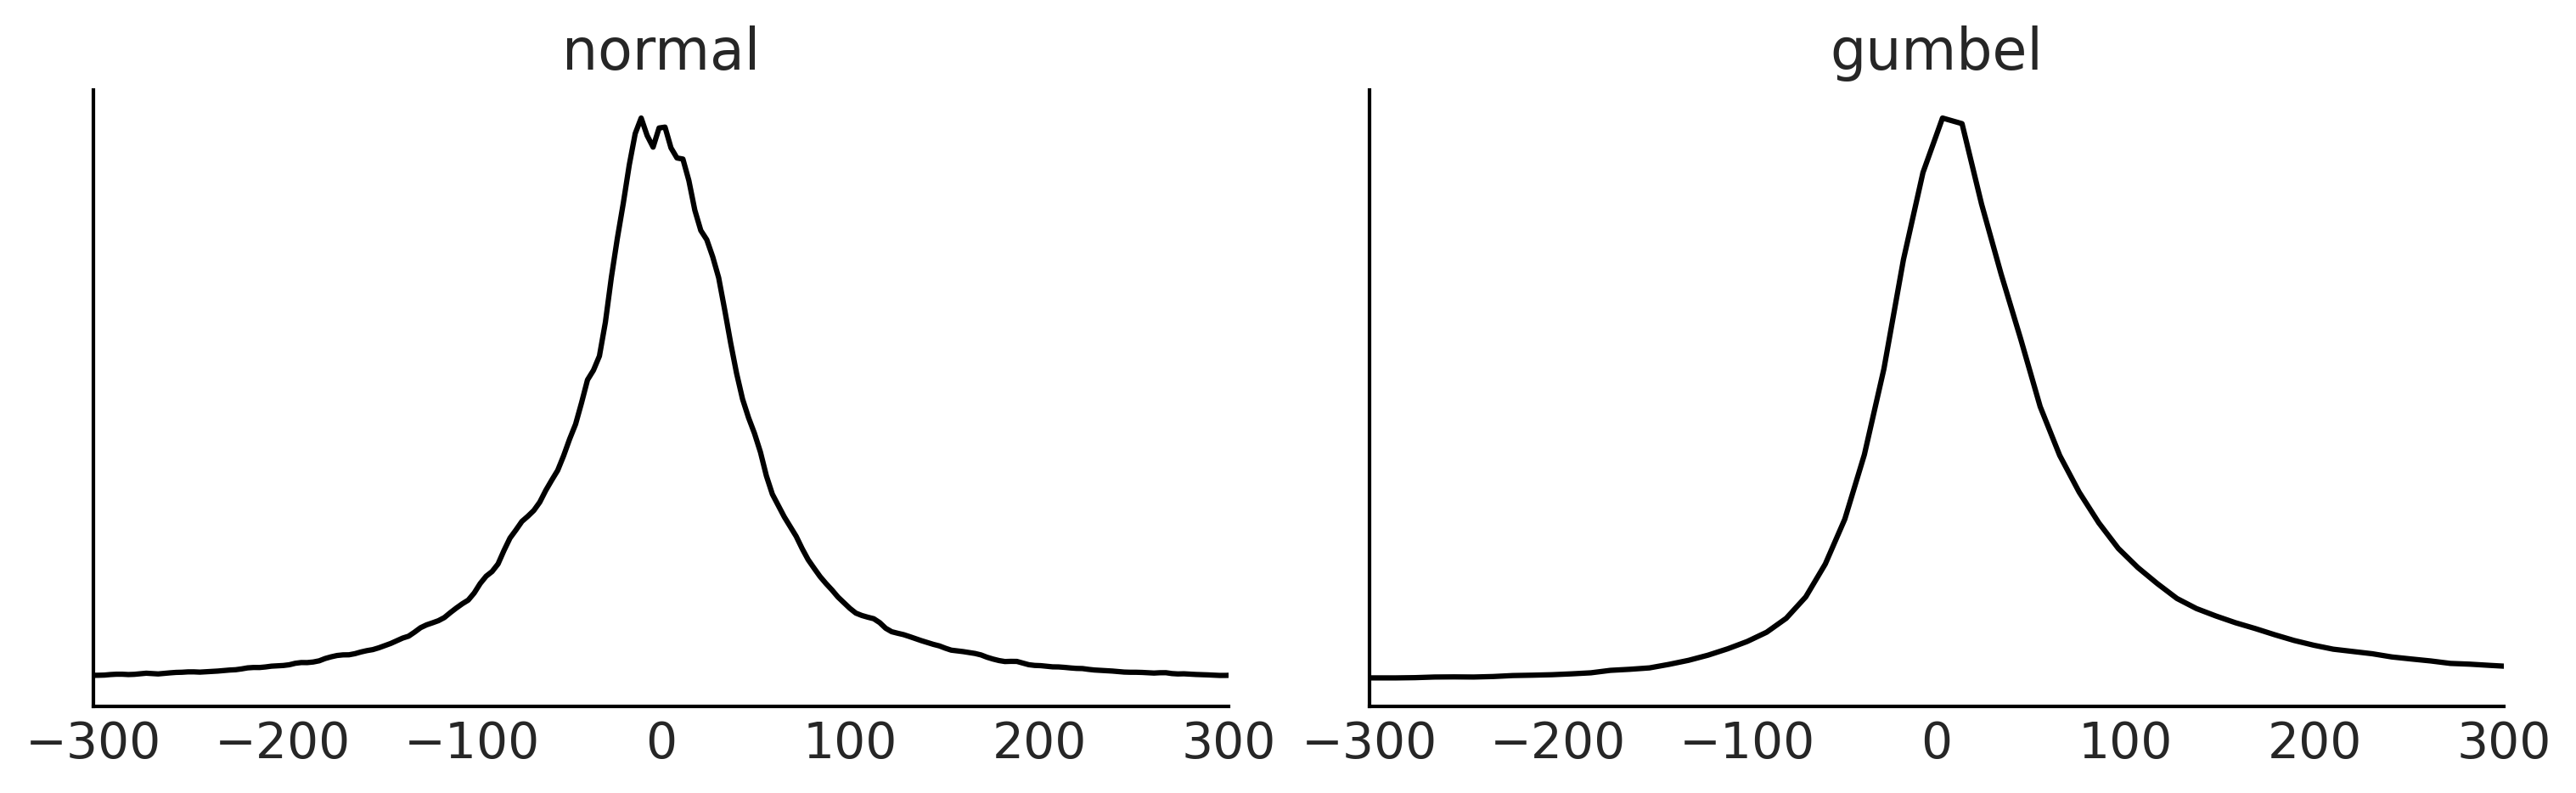

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

prior_predictives = {"normal":normal_prior_predictive, "gumbel": gumbel_predictive }

for i, (label, prior_predictive) in enumerate(prior_predictives.items()):
    
    data = prior_predictive.prior_predictive["delays"]
    az.plot_dist(data, ax=axes[i])
    axes[i].set_yticks([])
    axes[i].set_xlim(-300, 300)
    axes[i].set_title(label)
    
fig.savefig("img/chp09/Airline_Prior_Predictive.png")

## Inference and Inference Diagnostics

### Code 9.4

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


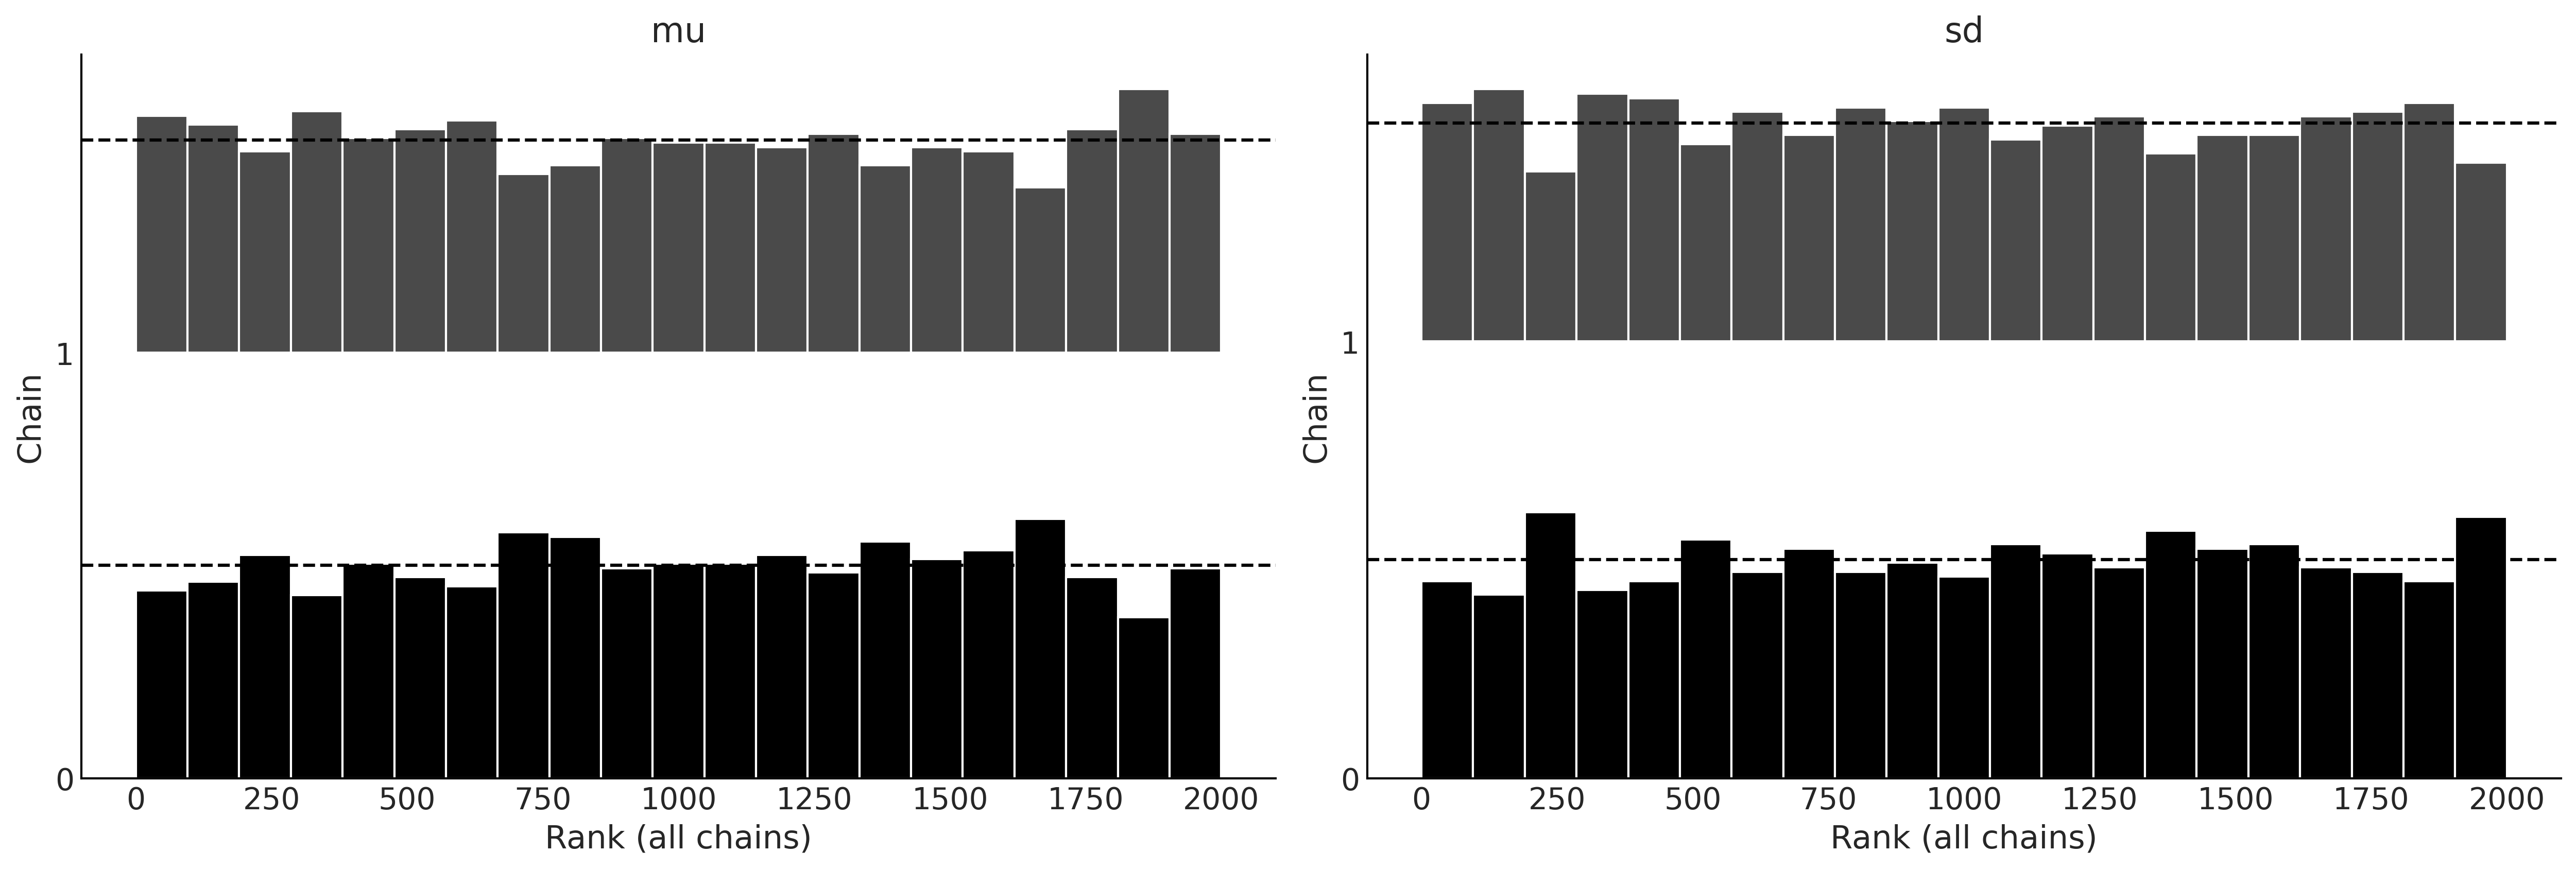

In [9]:
with normal_model:
    normal_data = pm.sample(random_seed=0, chains=2)
    az.plot_rank(normal_data)
plt.savefig('img/chp09/rank_plot_bars_normal.png')

### Figure 9.5

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, mu]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


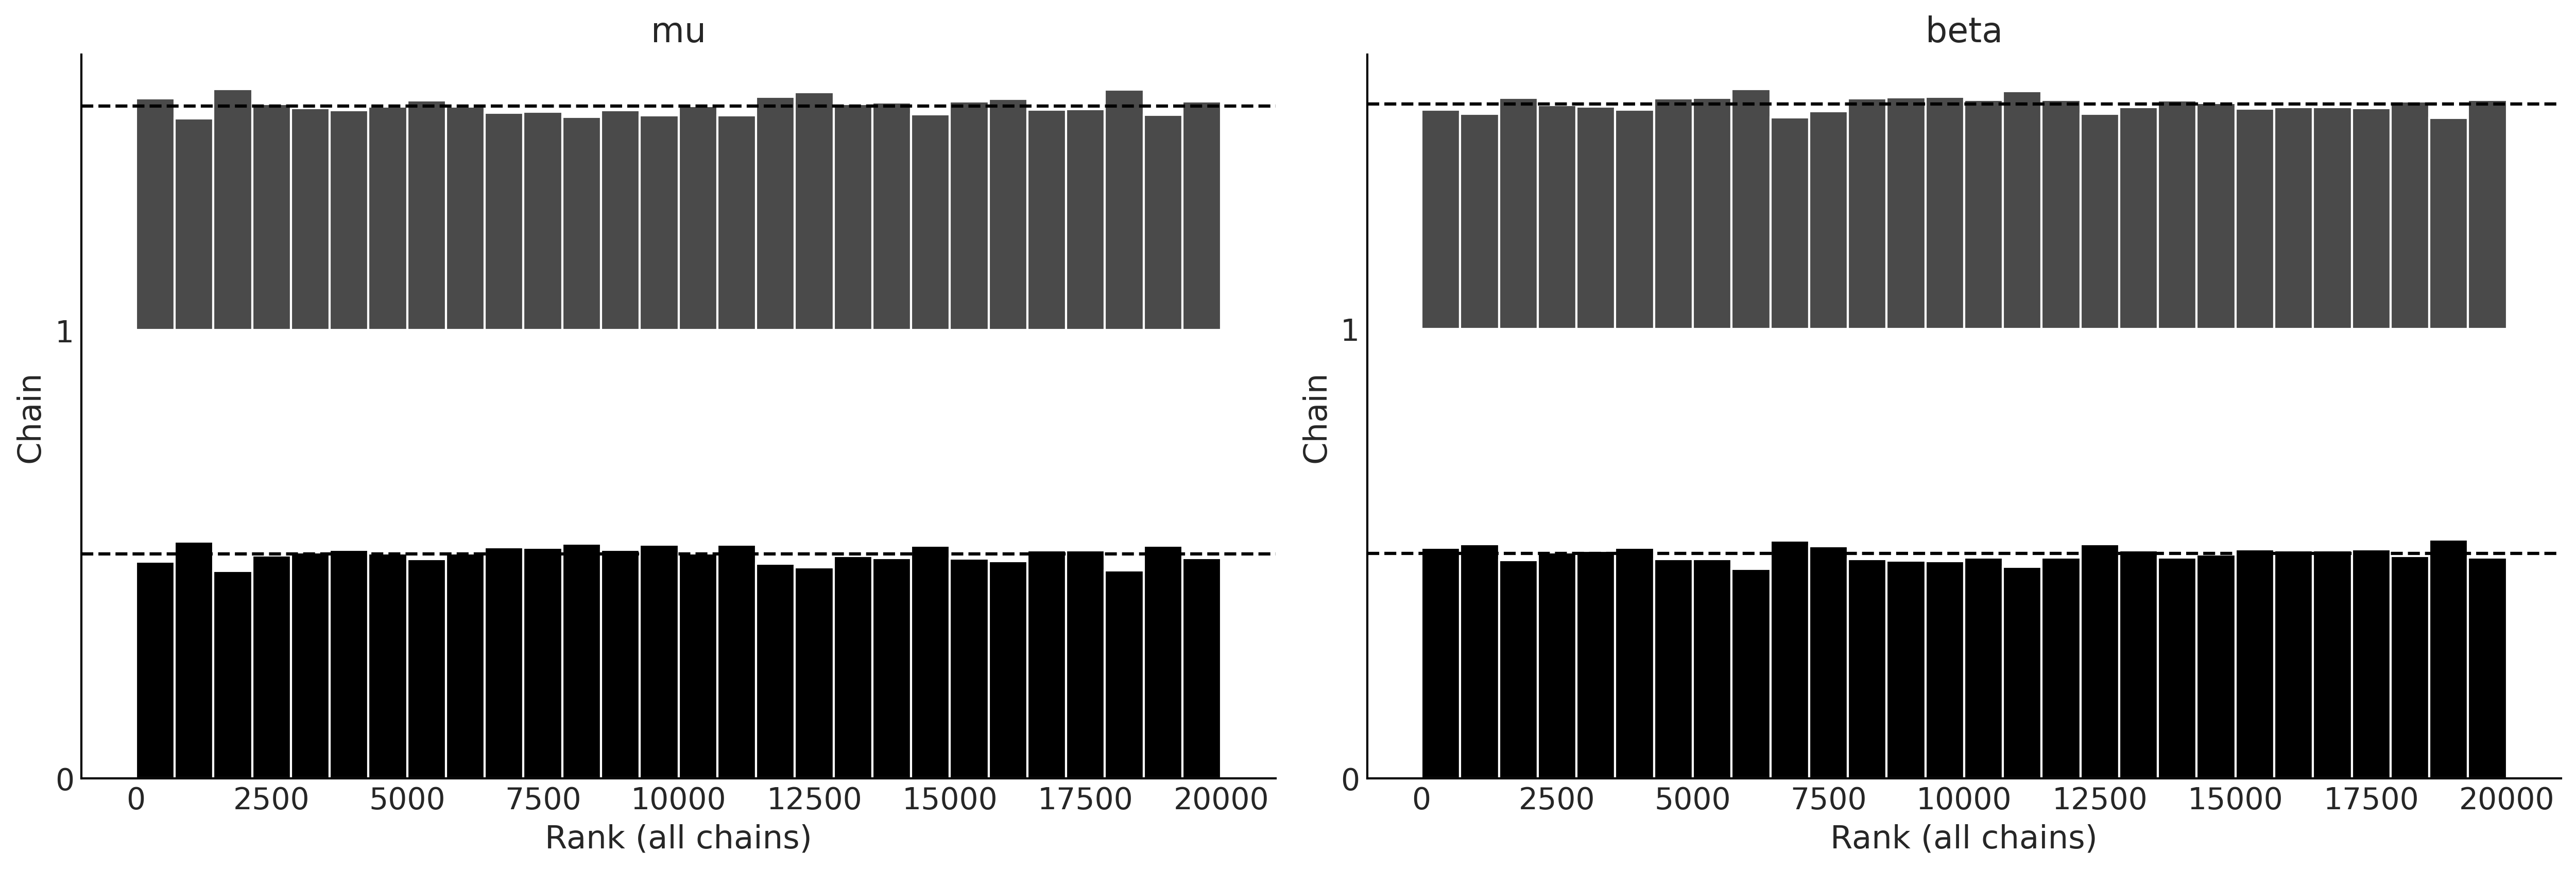

In [10]:
with gumbel_model:
    gumbel_data = pm.sample(random_seed=0, chains=2, draws=10000, idata_kwargs={"log_likelihood": True})
    az.plot_rank(gumbel_data)
plt.savefig('img/chp09/rank_plot_bars_gumbel.png')

## Posterior Plots

### Figure 9.6

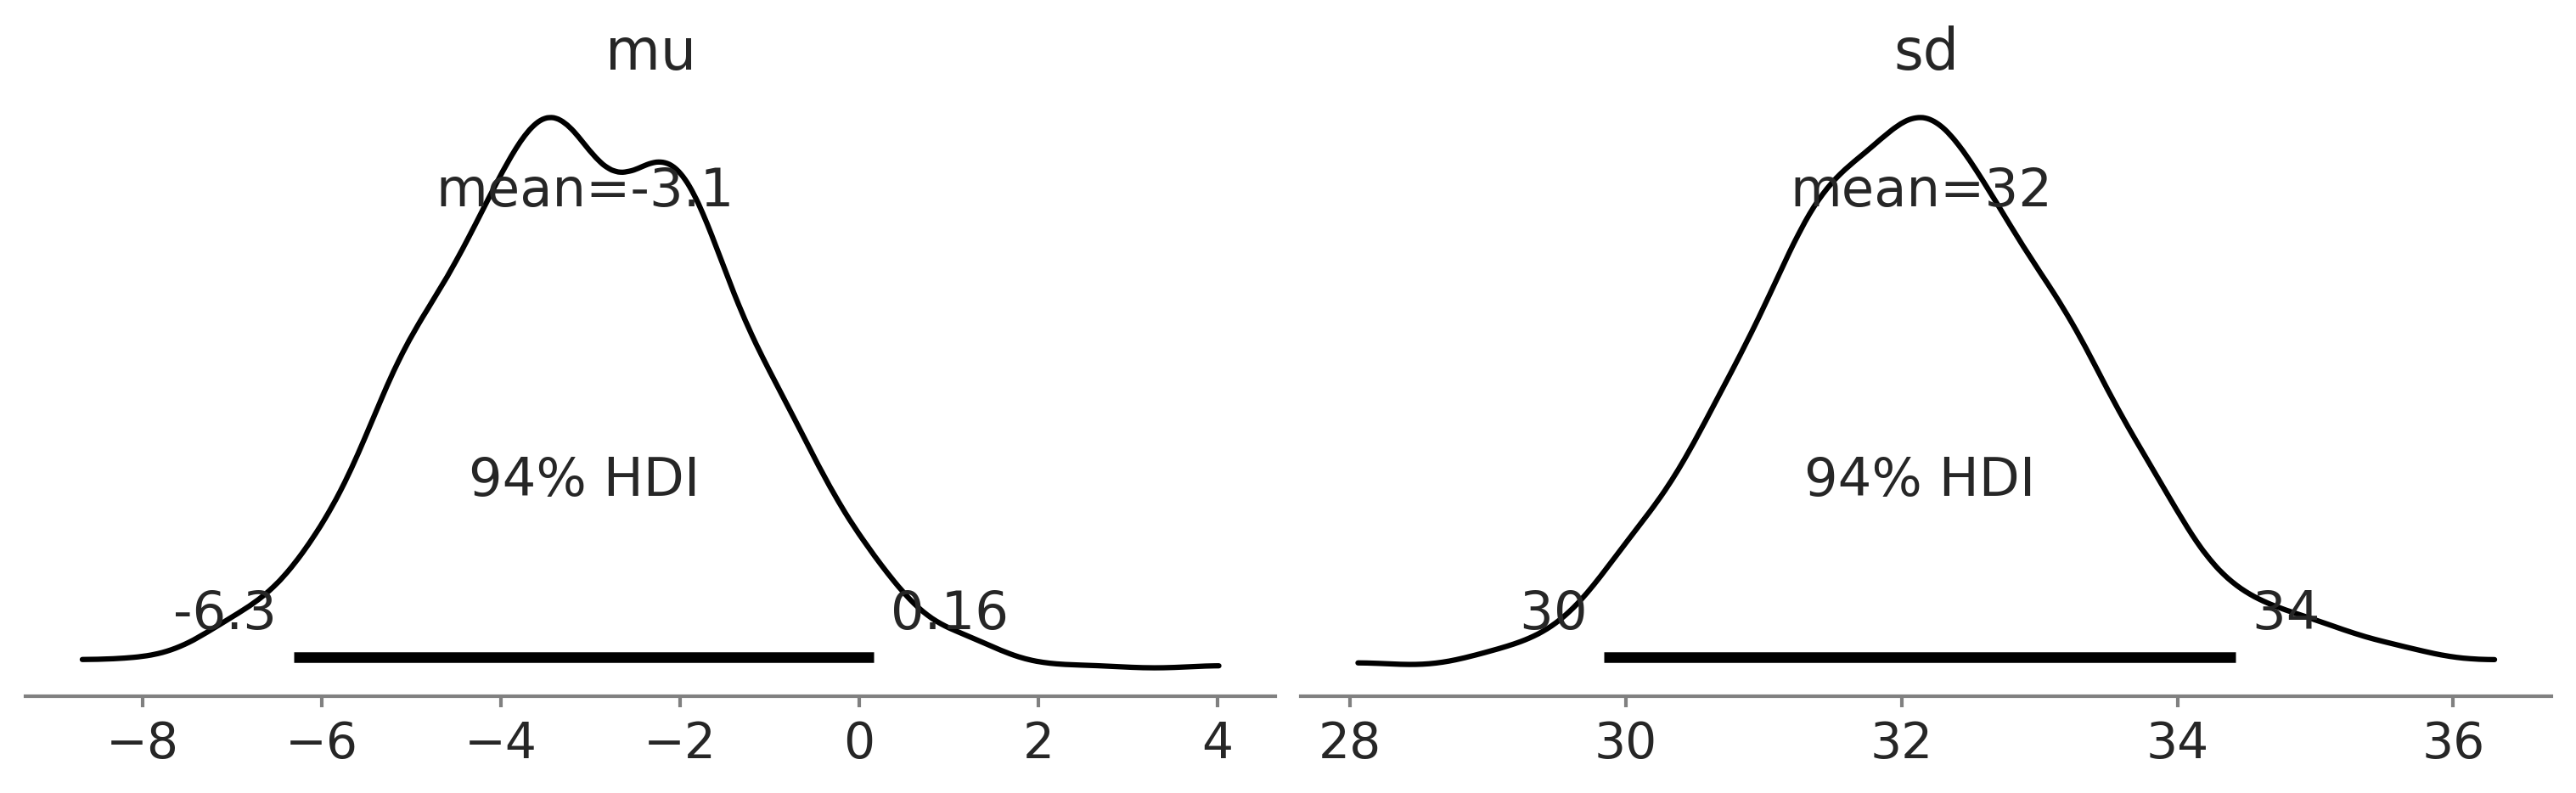

In [11]:
az.plot_posterior(normal_data, figsize=(10, 3))
plt.savefig('img/chp09/posterior_plot_delays_normal.png');

### Figure 9.7

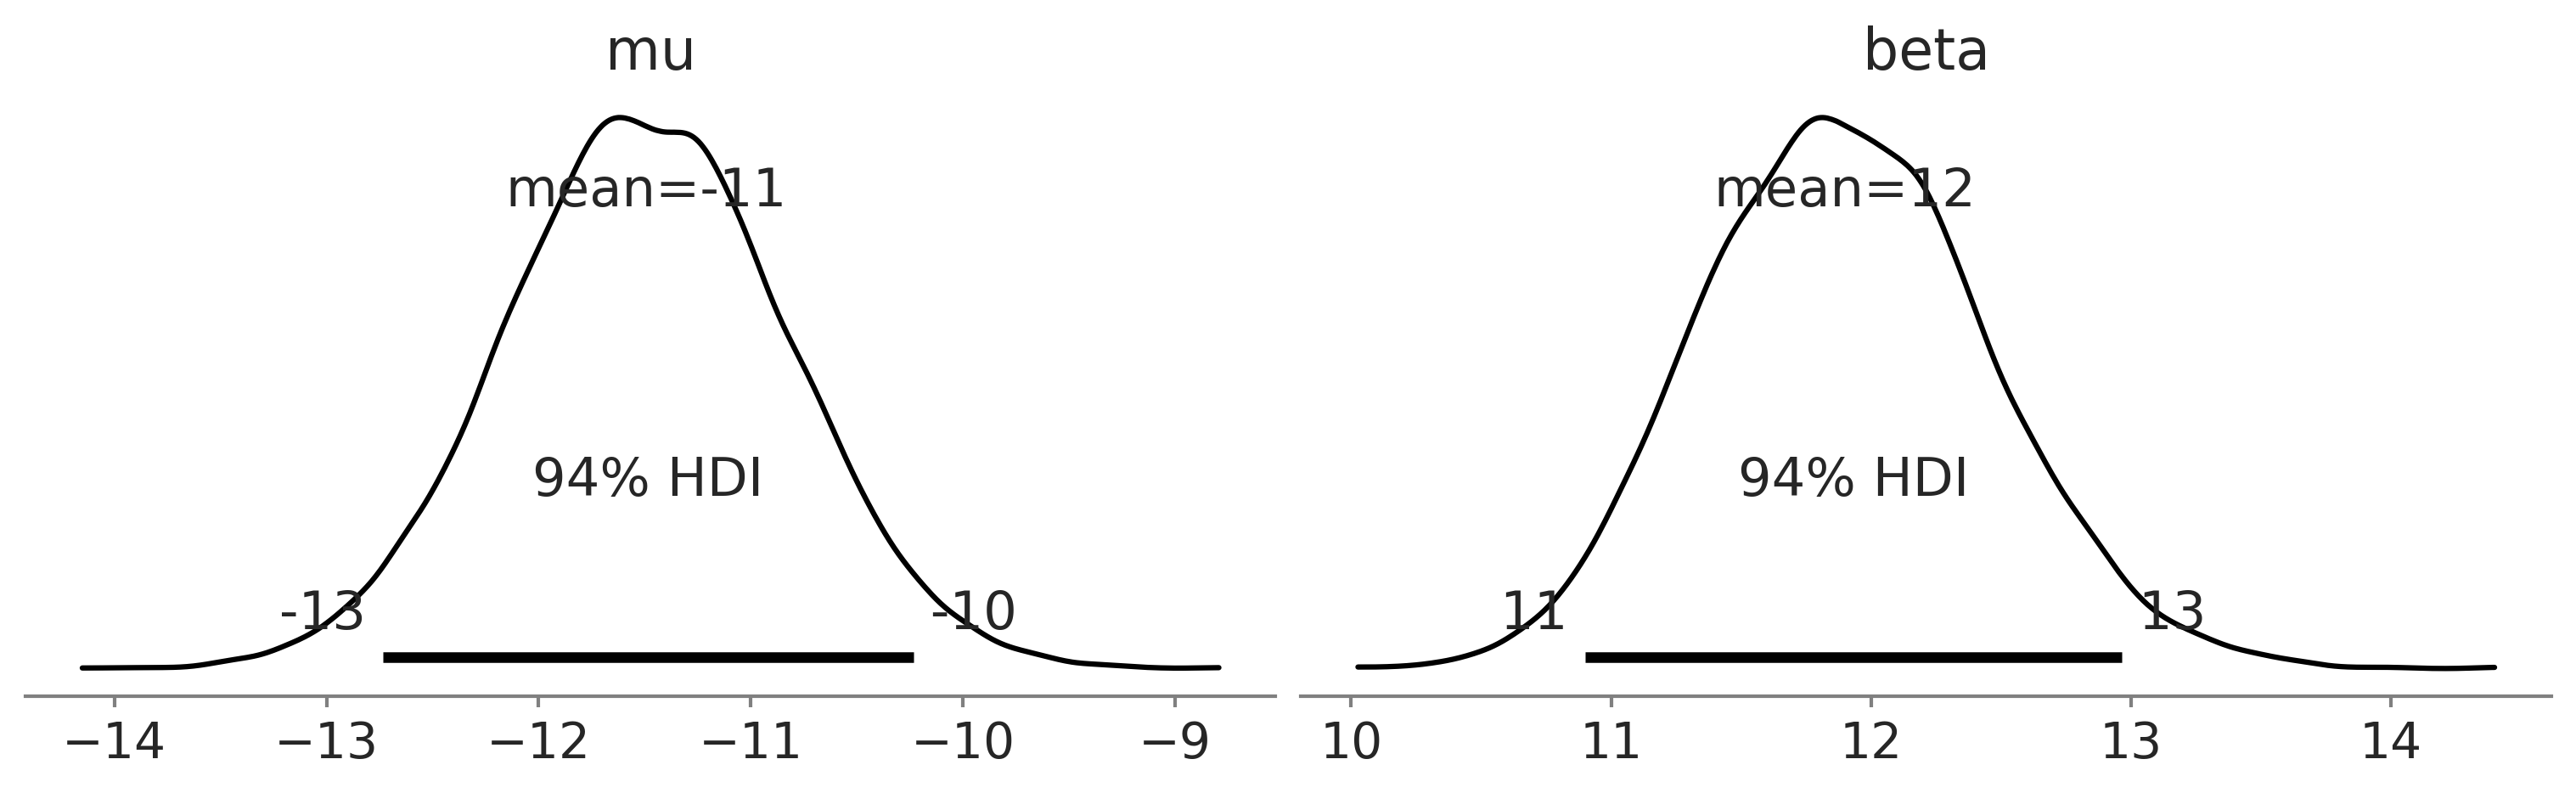

In [12]:
az.plot_posterior(gumbel_data, figsize=(10, 3))
plt.savefig('img/chp09/posterior_plot_delays_gumbel.png');

## Evaluating Posterior Predictive Distributions

### Code 9.5

In [13]:
with normal_model:
    normal_data = pm.sample(random_seed=0, idata_kwargs={"log_likelihood": True})
    normal_data.extend(pm.sample_posterior_predictive(normal_data, random_seed=0))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [delays]


array([<Axes: xlabel='delays'>], dtype=object)

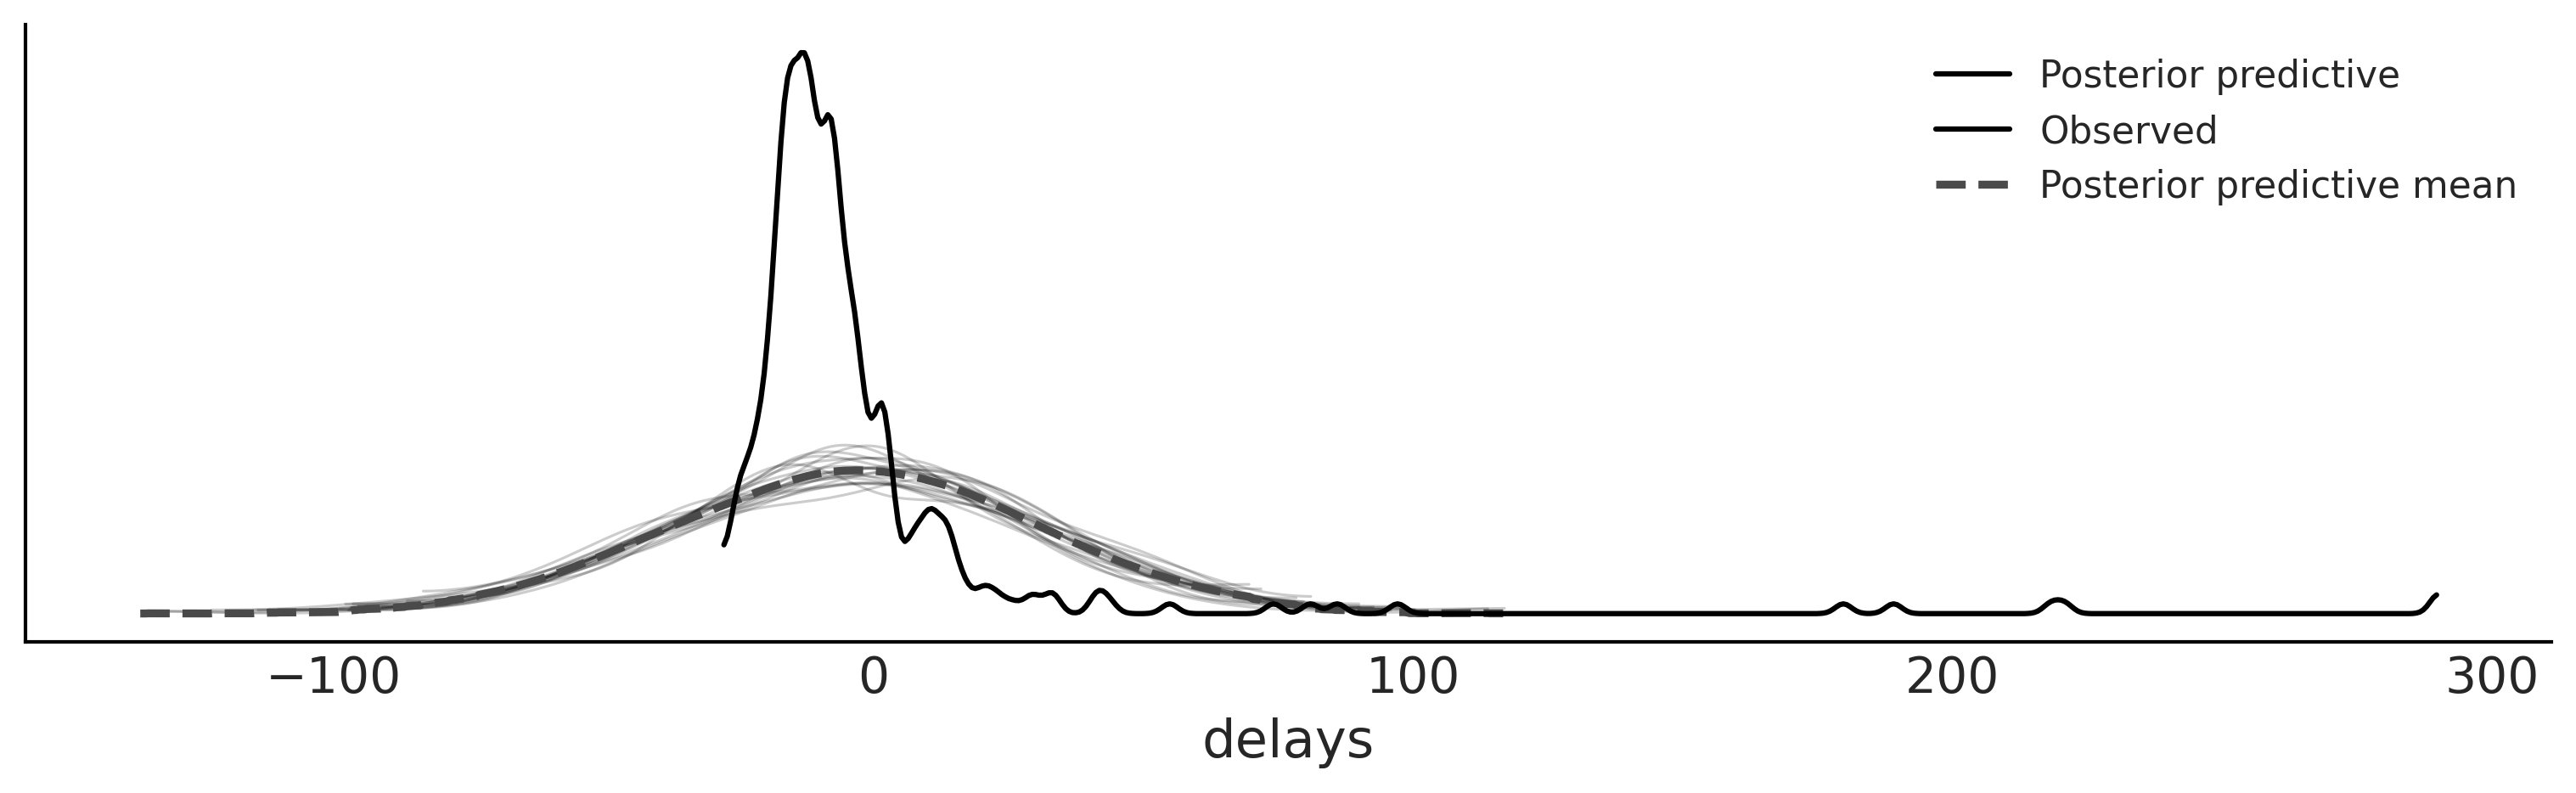

In [14]:
fig, ax = plt.subplots(figsize=(10, 3))
az.plot_ppc(normal_data, observed=True, num_pp_samples=20, ax=ax)

## Gumbel Posterior Predictive

In [15]:
with gumbel_model:
    gumbel_data.extend(pm.sample_posterior_predictive(gumbel_data, random_seed=0))

Sampling: [delays]


### Figure 9.8

/home/osvaldo/proyectos/00_BM/arviz-devs/arviz/arviz/plots/ppcplot.py:240: FutureWarning: color has been deprecated in favor of colors
  warnings.warn("color has been deprecated in favor of colors", FutureWarning)


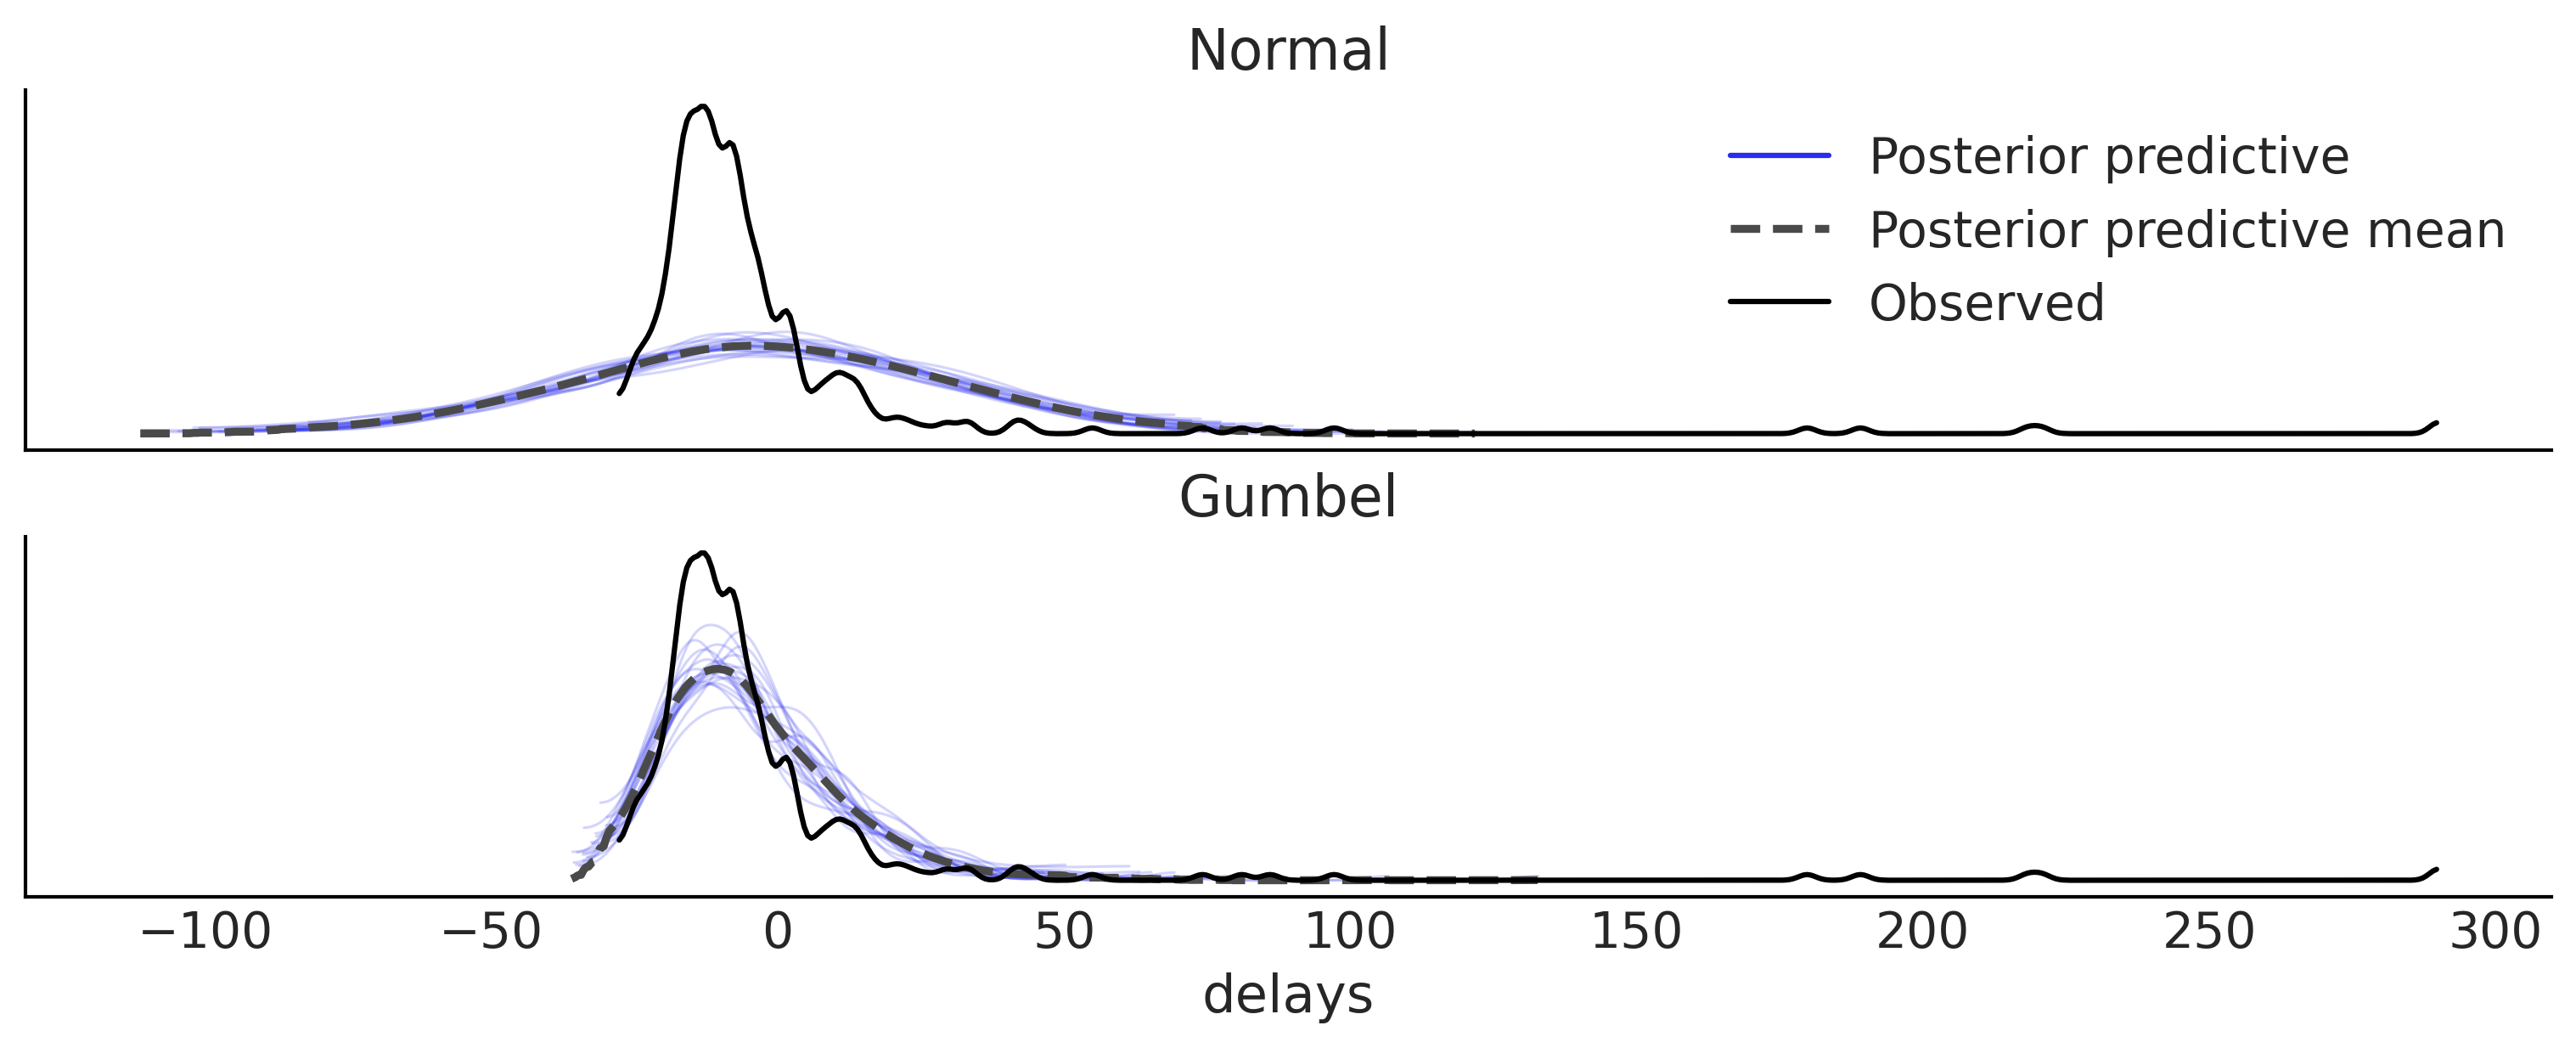

In [16]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(10, 4))

az.plot_ppc(normal_data, observed=False, num_pp_samples=20, ax=ax[0], color="C4")
az.plot_kde(msn_arrivals.values, ax=ax[0], label="Observed");

az.plot_ppc(gumbel_data, observed=False, num_pp_samples=20, ax=ax[1], color="C4")
az.plot_kde(msn_arrivals.values, ax=ax[1], label="Observed");
ax[0].set_title("Normal")
ax[0].set_xlabel("")
ax[1].set_title("Gumbel")
ax[1].legend().remove()
plt.savefig("img/chp09/delays_model_posterior_predictive.png")

### Figure 9.9

In [17]:
gumbel_late = gumbel_data.posterior_predictive["delays"].values.reshape(-1, 336).copy()
dist_of_late = (gumbel_late > 0).sum(axis=1) / 336

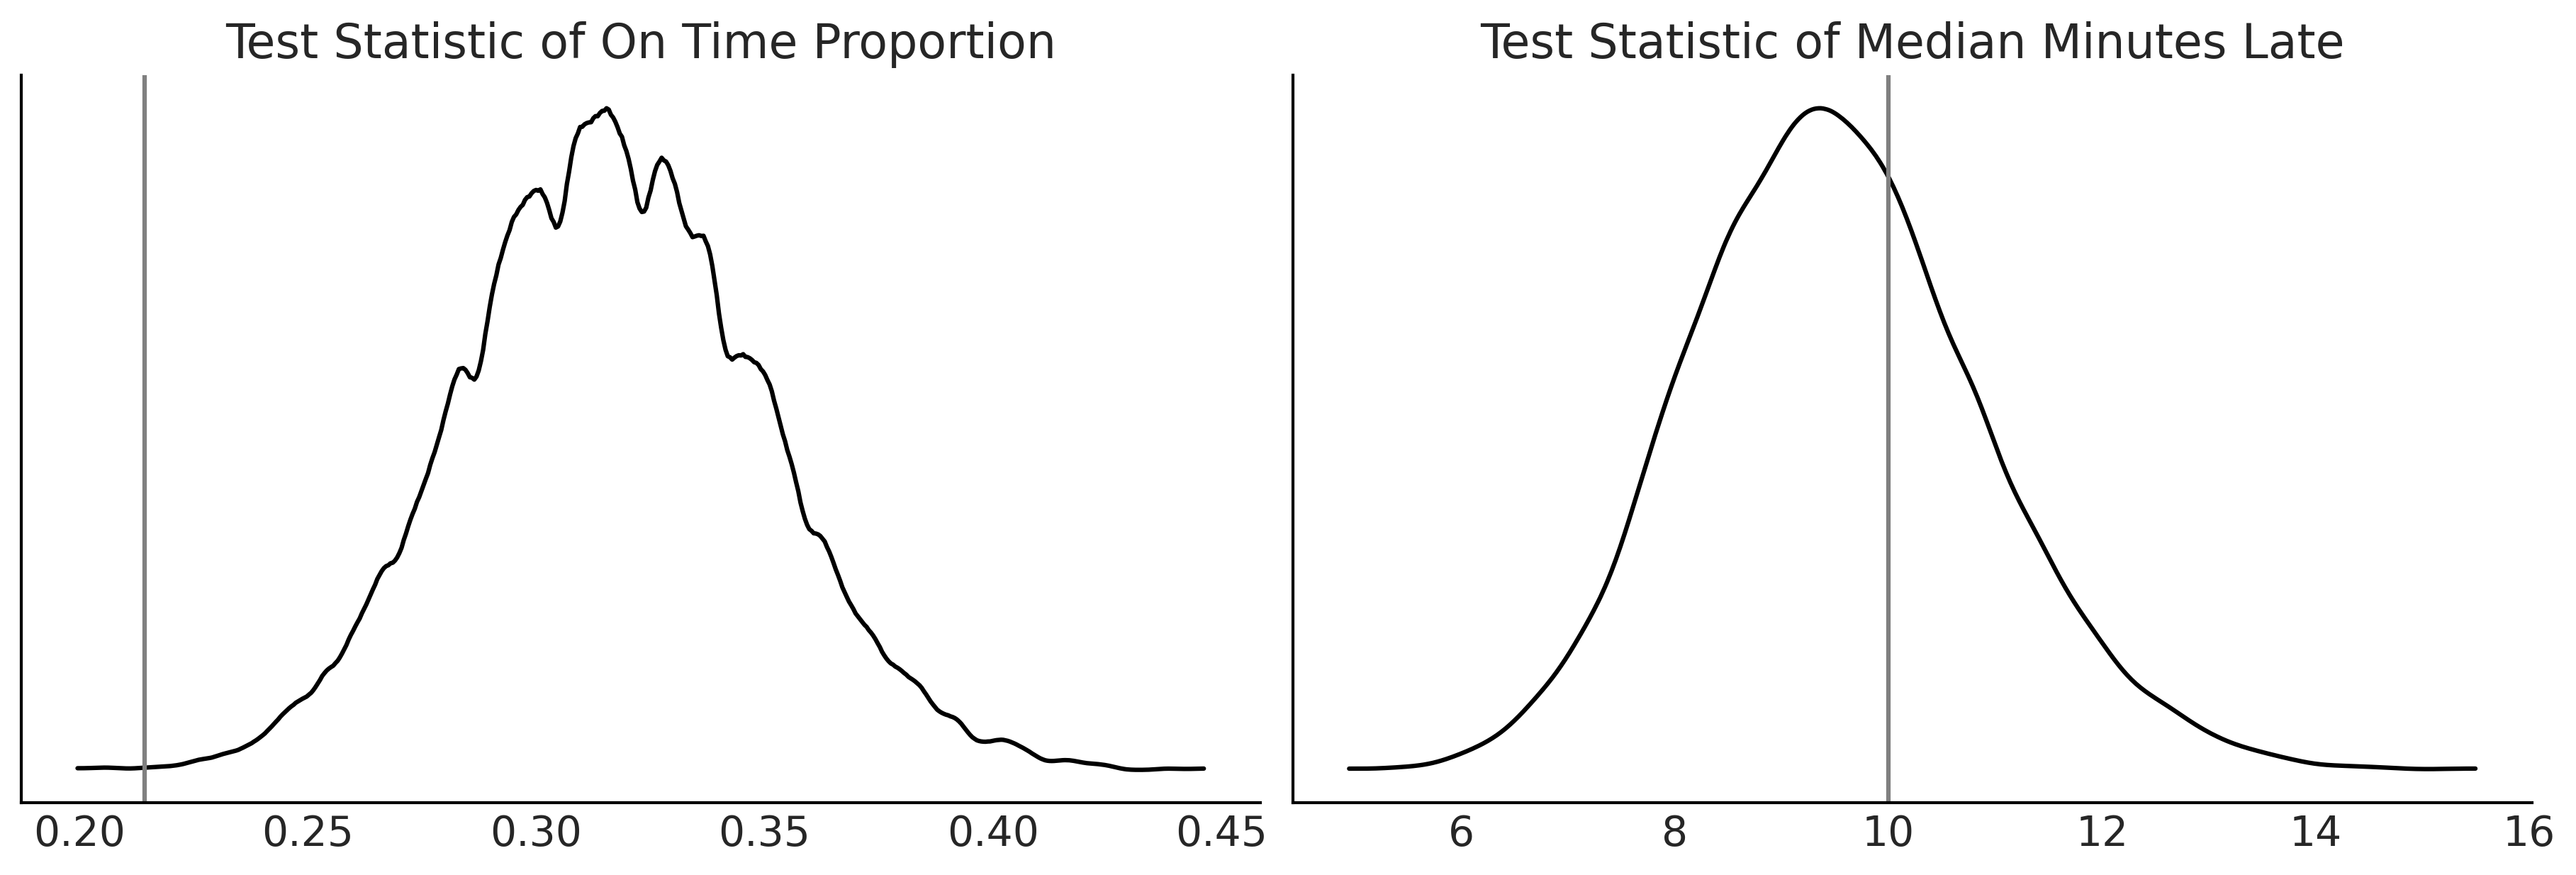

In [18]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

gumbel_late = gumbel_data.posterior_predictive["delays"].values.reshape(-1, 336).copy()
dist_of_late = (gumbel_late > 0).sum(axis=1) / 336
az.plot_dist(dist_of_late, ax=axes[0])

percent_observed_late = (msn_arrivals > 0).sum() / 336
axes[0].axvline(percent_observed_late, c="gray")
axes[0].set_title("Test Statistic of On Time Proportion")
axes[0].set_yticks([])


gumbel_late[gumbel_late < 0] = np.nan
median_lateness = np.nanmedian(gumbel_late, axis=1)
az.plot_dist(median_lateness,  ax=axes[1])

median_time_observed_late = msn_arrivals[msn_arrivals >= 0].median()
axes[1].axvline(median_time_observed_late, c="gray")
axes[1].set_title("Test Statistic of Median Minutes Late")
axes[1].set_yticks([])

plt.savefig("img/chp09/arrival_test_statistics_for_gumbel_posterior_predictive.png")

## Model Comparison

### Code 9.6

In [19]:
compare_dict = {"normal": normal_data,"gumbel": gumbel_data}
comp = az.compare(compare_dict)
comp

/home/osvaldo/proyectos/00_BM/arviz-devs/arviz/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/osvaldo/proyectos/00_BM/arviz-devs/arviz/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/osvaldo/proyectos/00_BM/arviz-devs/arviz/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with flo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
gumbel,0,-1410.218437,5.667718,0.000000,1.0,45.130236,0.000000,False,log
normal,1,-1653.936801,21.466577,243.718363,0.0,65.361236,27.707668,True,log


### Figure 9.10

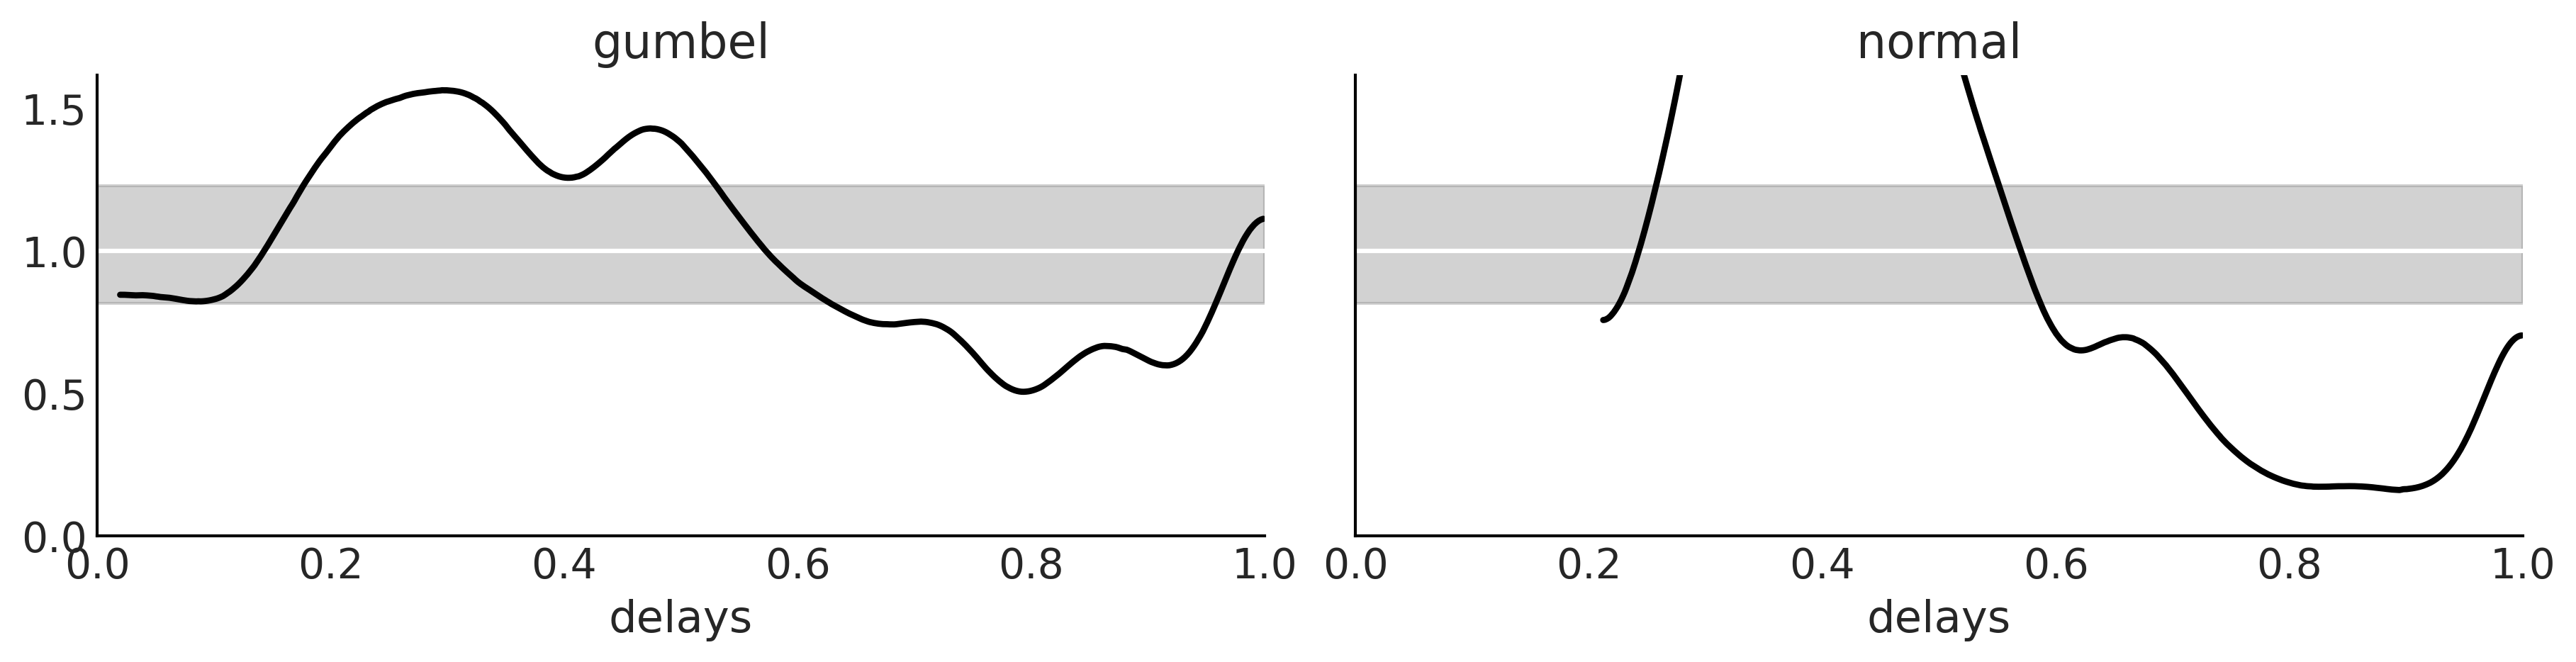

In [20]:
_, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)
for label, model, ax in zip(("gumbel", "normal"),(gumbel_data, normal_data), axes):
    az.plot_loo_pit(model, y="delays", legend=False, use_hdi=True, ax=ax)
    ax.set_title(label)
    
plt.savefig('img/chp09/loo_pit_delays.png')

### Table 9.1

In [21]:
cmp_dict = {"gumbel": gumbel_data,
            "normal": normal_data}
            
cmp = az.compare(cmp_dict)
cmp

/home/osvaldo/proyectos/00_BM/arviz-devs/arviz/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/osvaldo/proyectos/00_BM/arviz-devs/arviz/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/osvaldo/proyectos/00_BM/arviz-devs/arviz/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with flo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
gumbel,0,-1410.218437,5.667718,0.000000,1.0,45.130236,0.000000,False,log
normal,1,-1653.936801,21.466577,243.718363,0.0,65.361236,27.707668,True,log


### Code 9.7 and Figure 9.12

/home/osvaldo/proyectos/00_BM/arviz-devs/arviz/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


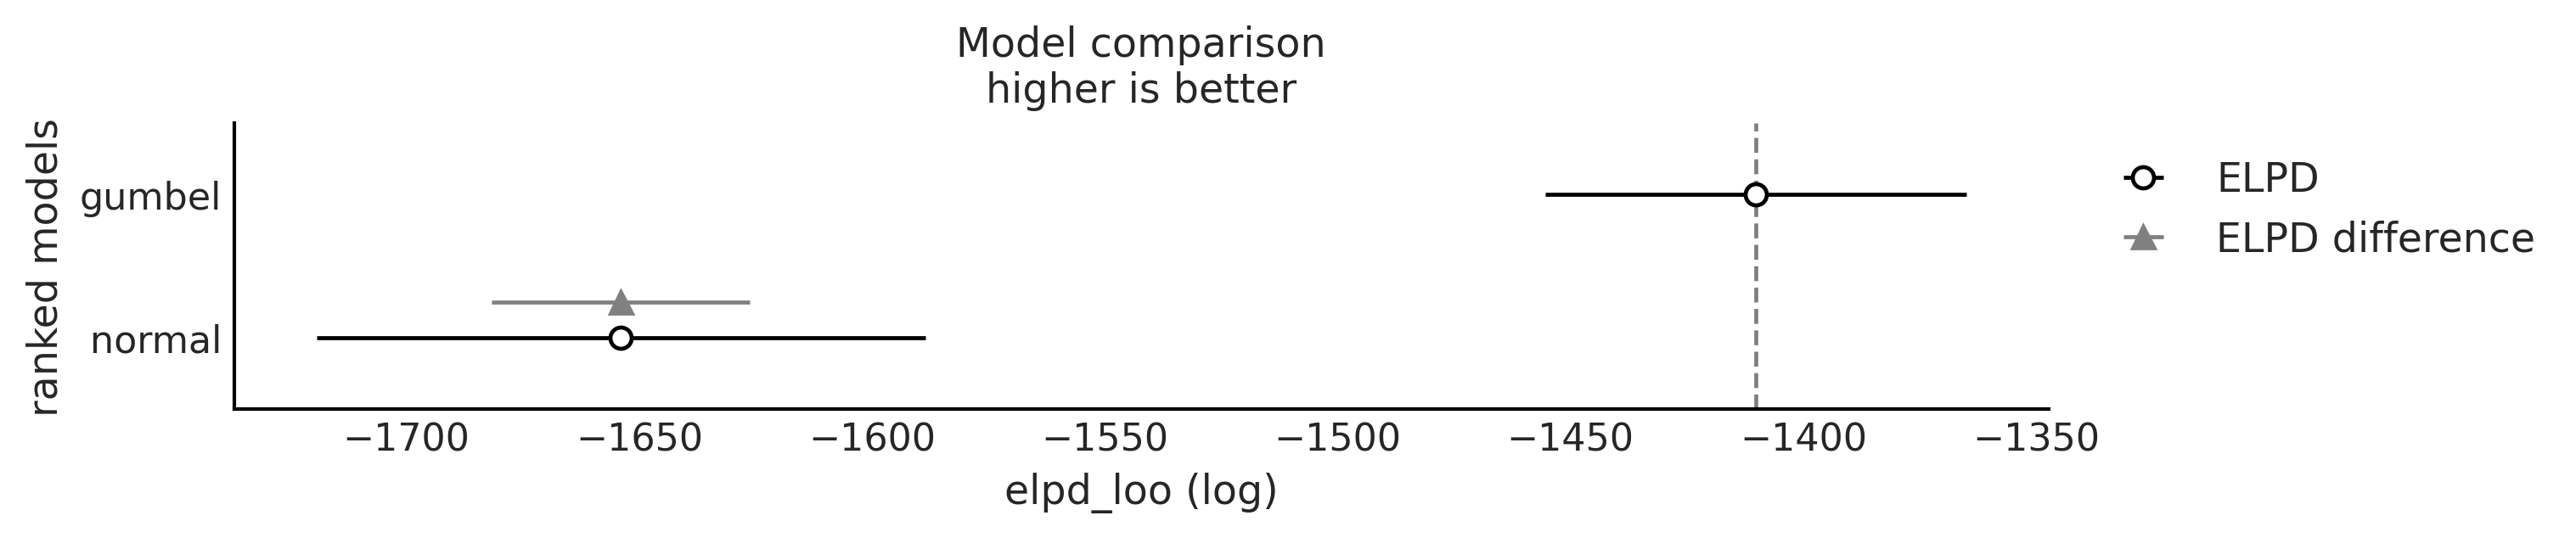

In [22]:
az.plot_compare(cmp, figsize=(10, 2))
plt.savefig("img/chp09/model_comparison_airlines.png")

### Figure 9.12

In [23]:
gumbel_loo = az.loo(gumbel_data, pointwise=True)
normal_loo = az.loo(normal_data, pointwise=True)

/home/osvaldo/proyectos/00_BM/arviz-devs/arviz/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


/home/osvaldo/proyectos/00_BM/arviz-devs/arviz/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


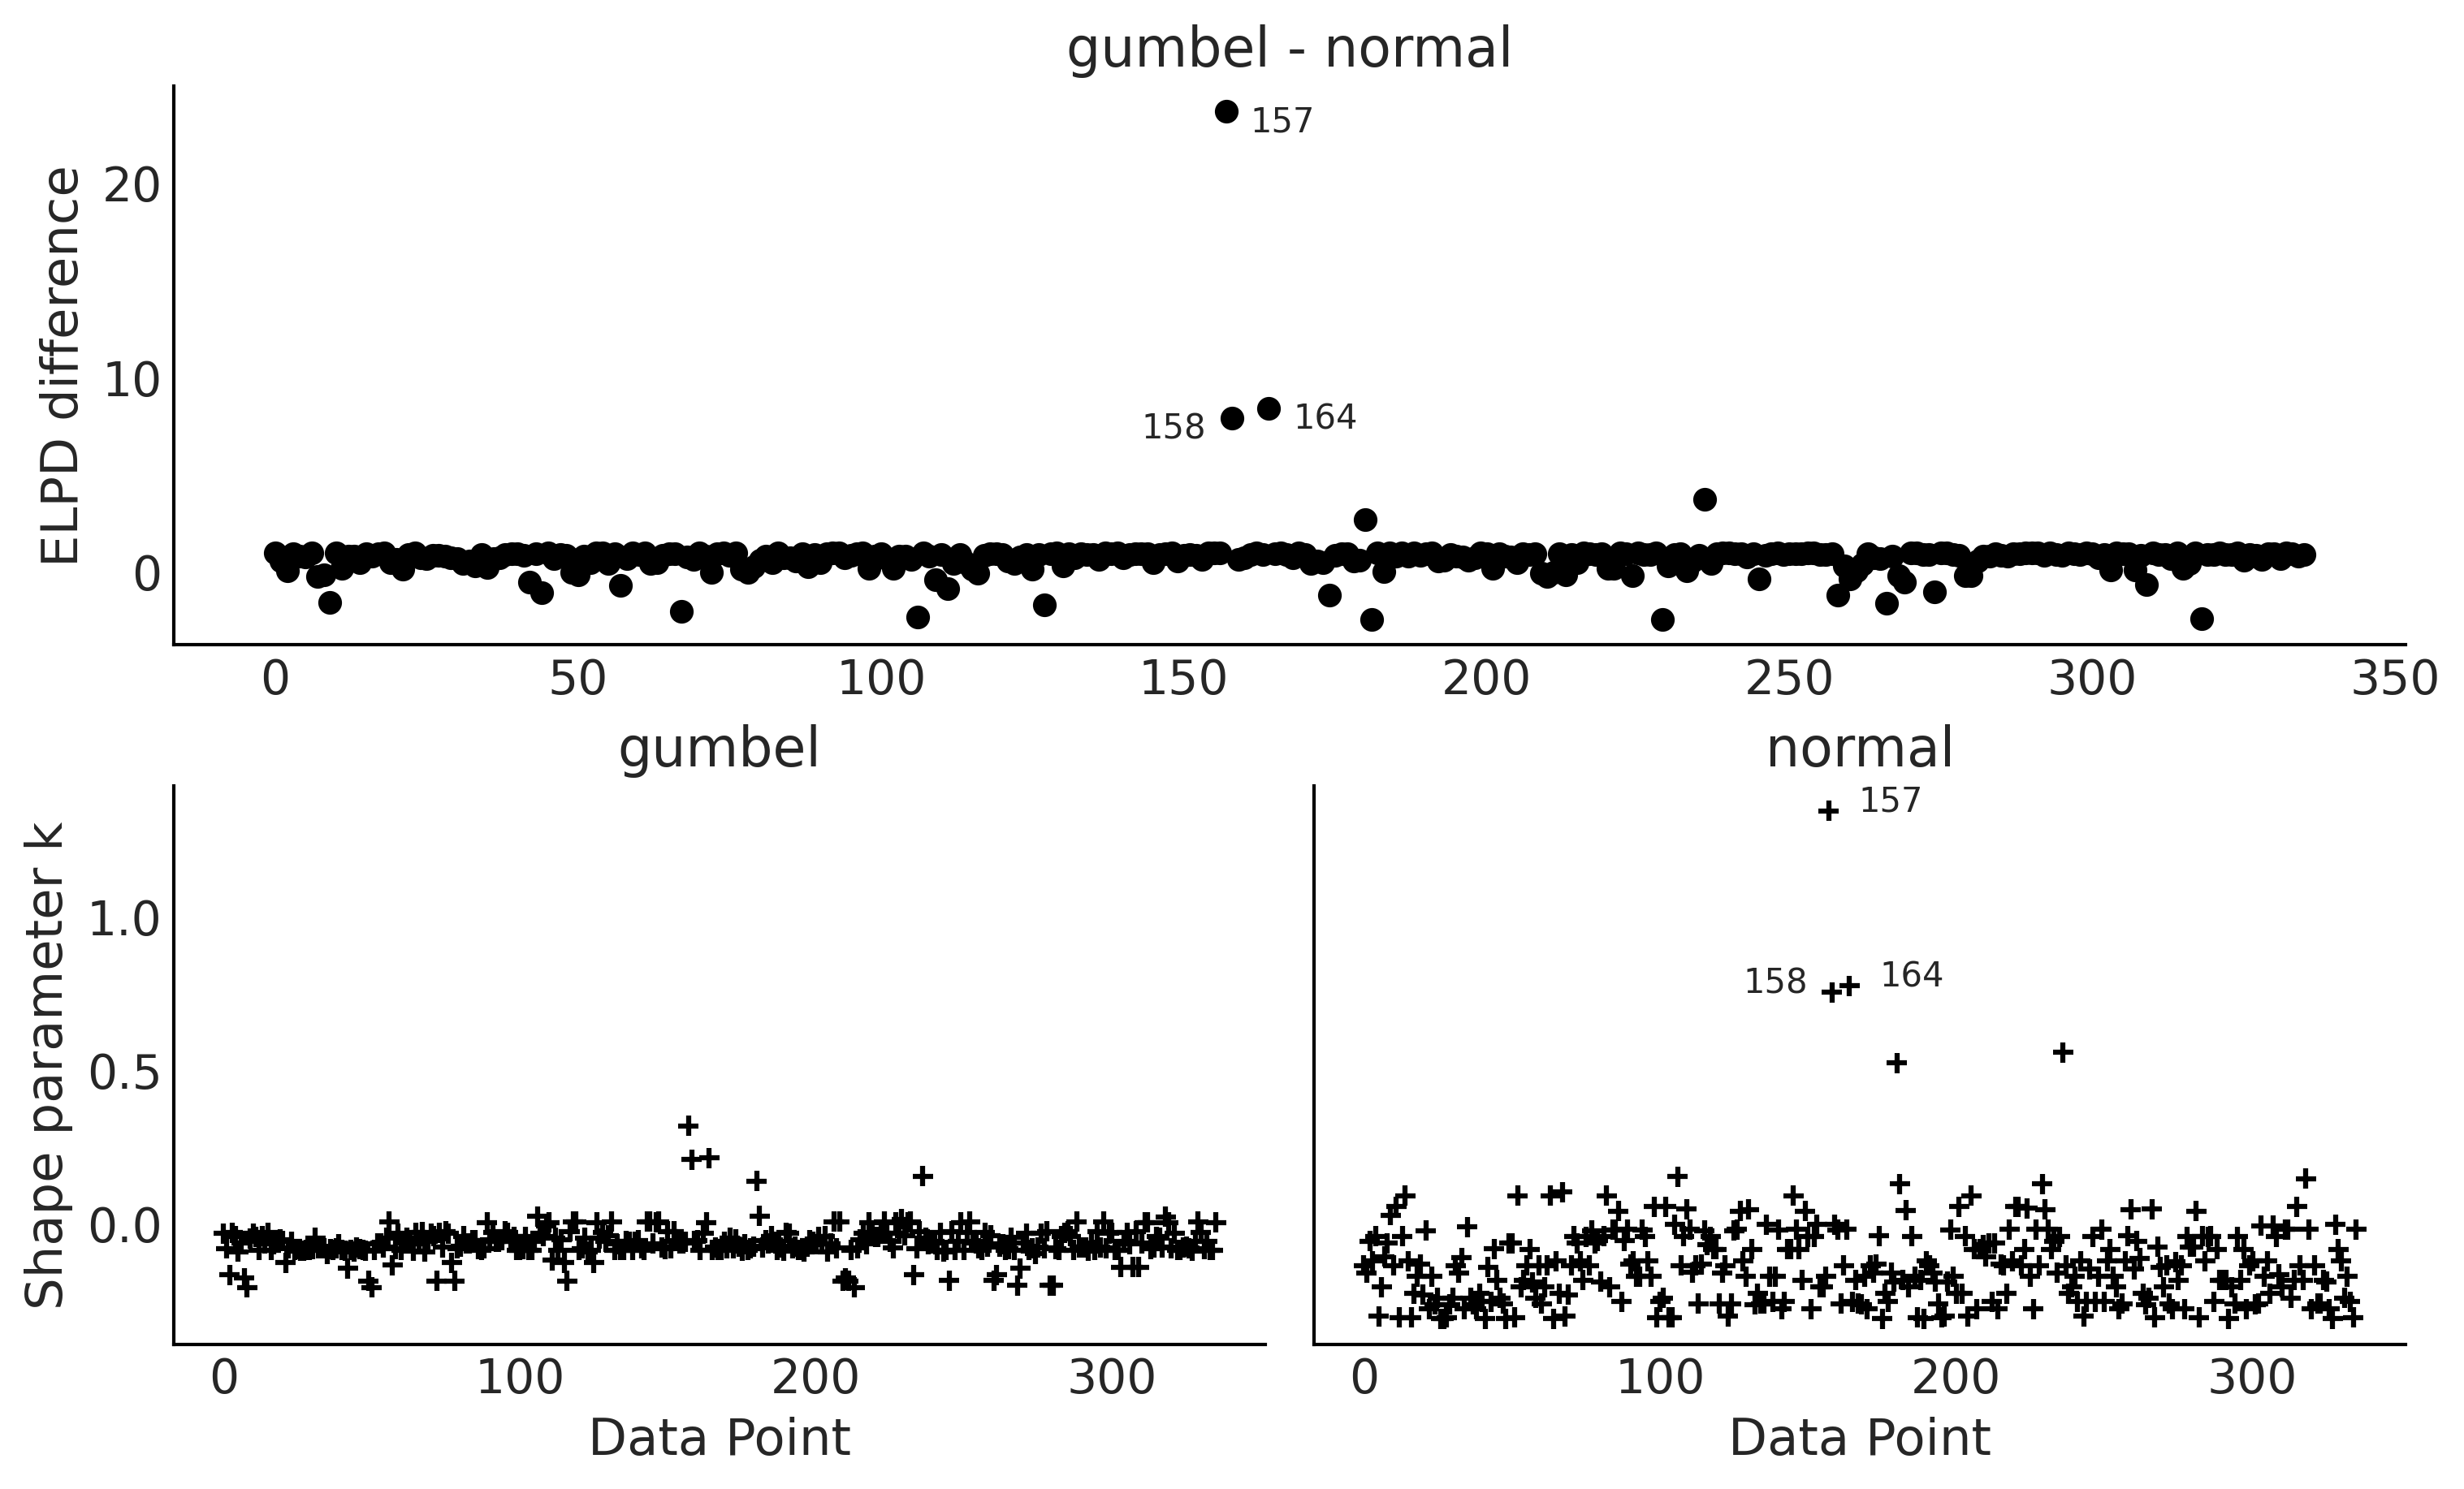

In [24]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2)

ax = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])


diff = gumbel_loo.loo_i - normal_loo.loo_i
idx = np.abs(diff) > 4
x_values = np.where(idx)[0]
y_values = diff[idx].values
az.plot_elpd(cmp_dict, ax=ax)

for x, y, in zip(x_values, y_values):
    if x != 158:
        x_pos = x+4
    else:
        x_pos = x-15
    ax.text(x_pos, y-1, x)
    
for label, elpd_data, ax in zip(("gumbel", "normal"),
                                (gumbel_loo, normal_loo), (ax1, ax2)):
    az.plot_khat(elpd_data, ax=ax)
    ax.set_title(label)
    idx = elpd_data.pareto_k > 0.7
    x_values = np.where(idx)[0]
    y_values = elpd_data.pareto_k[idx].values
    for x, y, in zip(x_values, y_values):
        if x != 158:
            x_pos = x+10
        else:
            x_pos = x-30
        ax.text(x_pos, y, x)
    

#     ttl = ax.title
#    ttl.set_position([.5, 10])

ax1.set_ylim(ax2.get_ylim())
ax2.set_ylabel("")
ax2.set_yticks([])
plt.savefig('img/chp09/elpd_plot_delays.png');

## Reward Functions and Decisions

In [25]:
posterior_pred = gumbel_data.posterior_predictive["delays"].values.reshape(-1, 336).copy()

### Code 9.8

In [26]:
@np.vectorize
def current_revenue(delay):
    """Calculates revenue """
    if delay >= 0:
        return 300.*delay
    return np.nan

### Code 9.9

In [27]:
def revenue_calculator(posterior_pred, revenue_func):    
    revenue_per_flight = revenue_func(posterior_pred)
    average_revenue = np.nanmean(revenue_per_flight)
    return revenue_per_flight, average_revenue

In [28]:
revenue_per_flight, average_revenue = revenue_calculator(posterior_pred, current_revenue)
average_revenue

3930.398226249302

### Figure 9.13

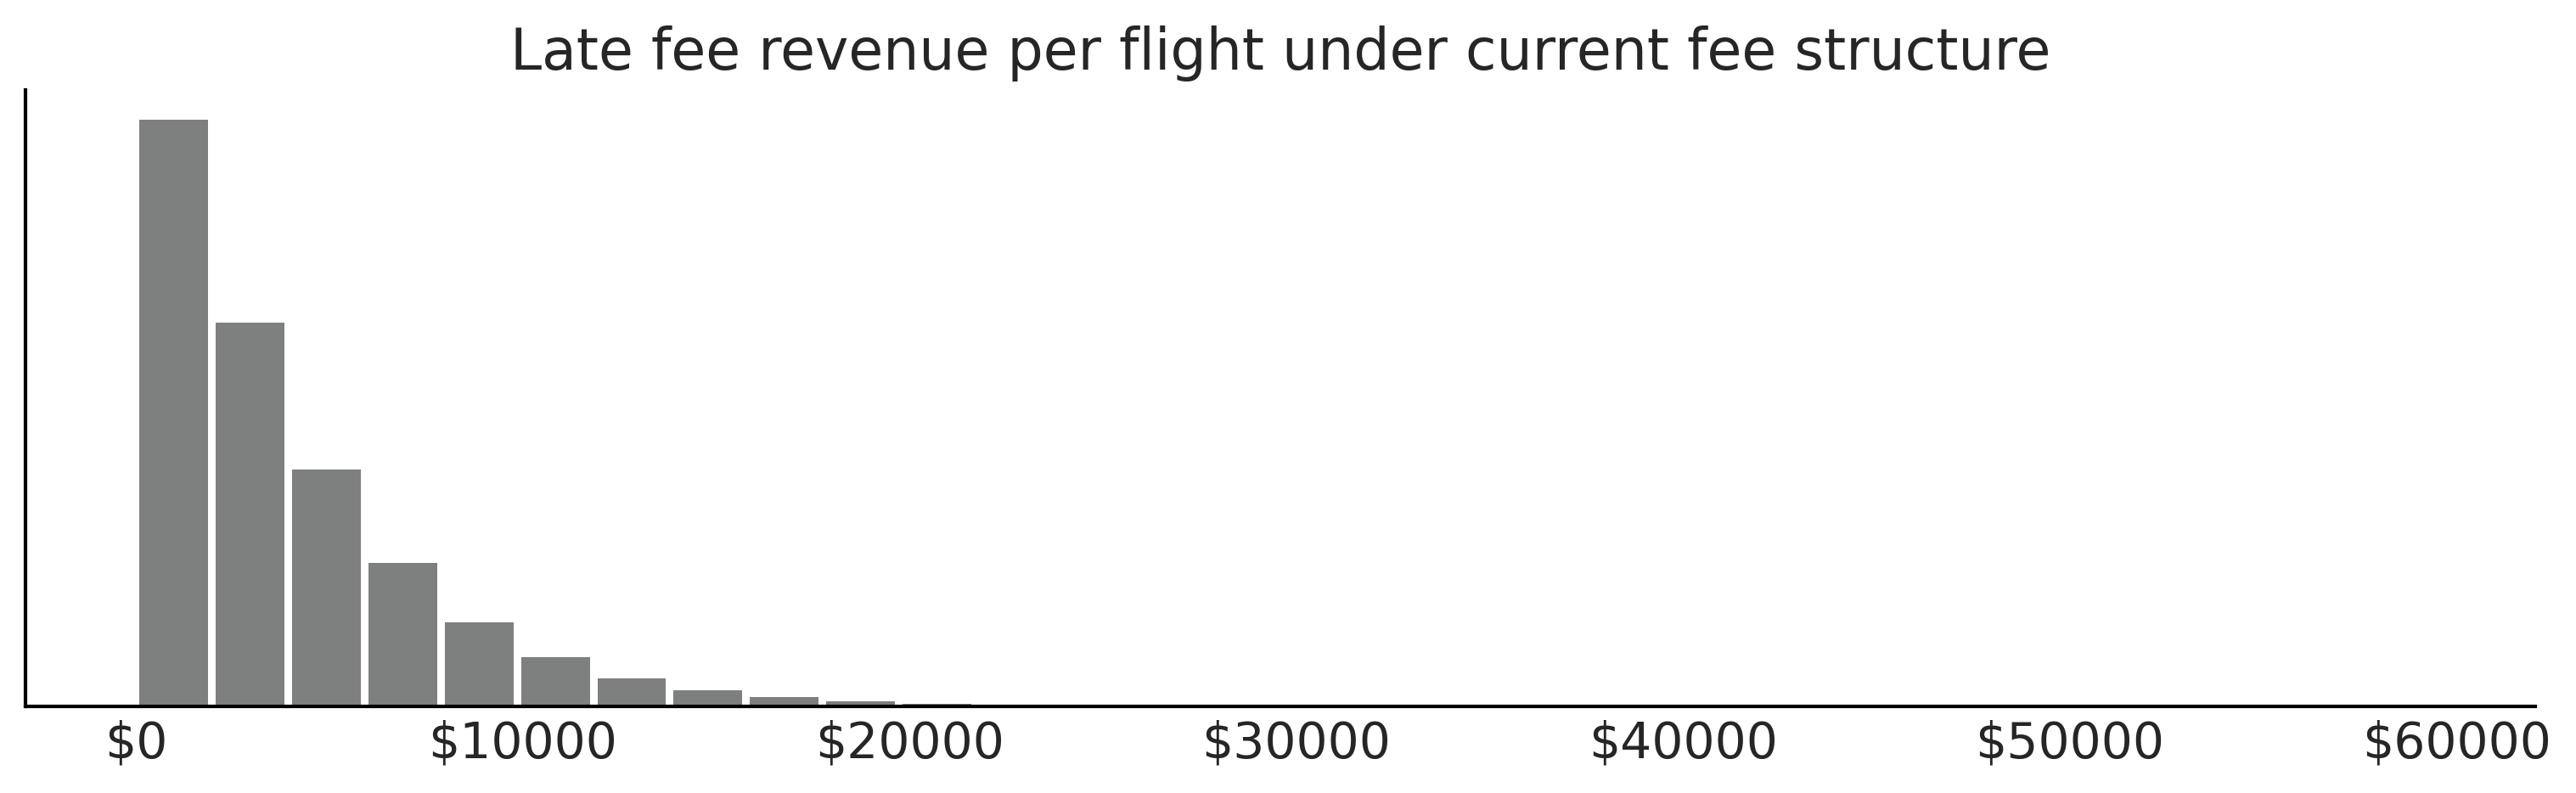

In [29]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.hist(revenue_per_flight.flatten(), bins=30, rwidth=.9, color="C2" )
ax.set_yticks([])
ax.set_title("Late fee revenue per flight under current fee structure")
ax.xaxis.set_major_formatter('${x:1.0f}')
plt.savefig("img/chp09/late_fee_current_structure_hist.png")

### Code 9.10

In [30]:
@np.vectorize
def proposed_revenue(delay):
    """Calculates revenue """
    if delay >= 100:
        return 30000.
    elif delay >= 10:
        return 5000.
    elif delay >= 0:
        return 1000.
    else:
        return np.nan


In [31]:
revenue_per_flight_proposed, average_revenue_proposed = revenue_calculator(posterior_pred, proposed_revenue)
average_revenue_proposed

2925.4244632990353

## Sharing the Results With a Particular Audience

### Figure 9.14

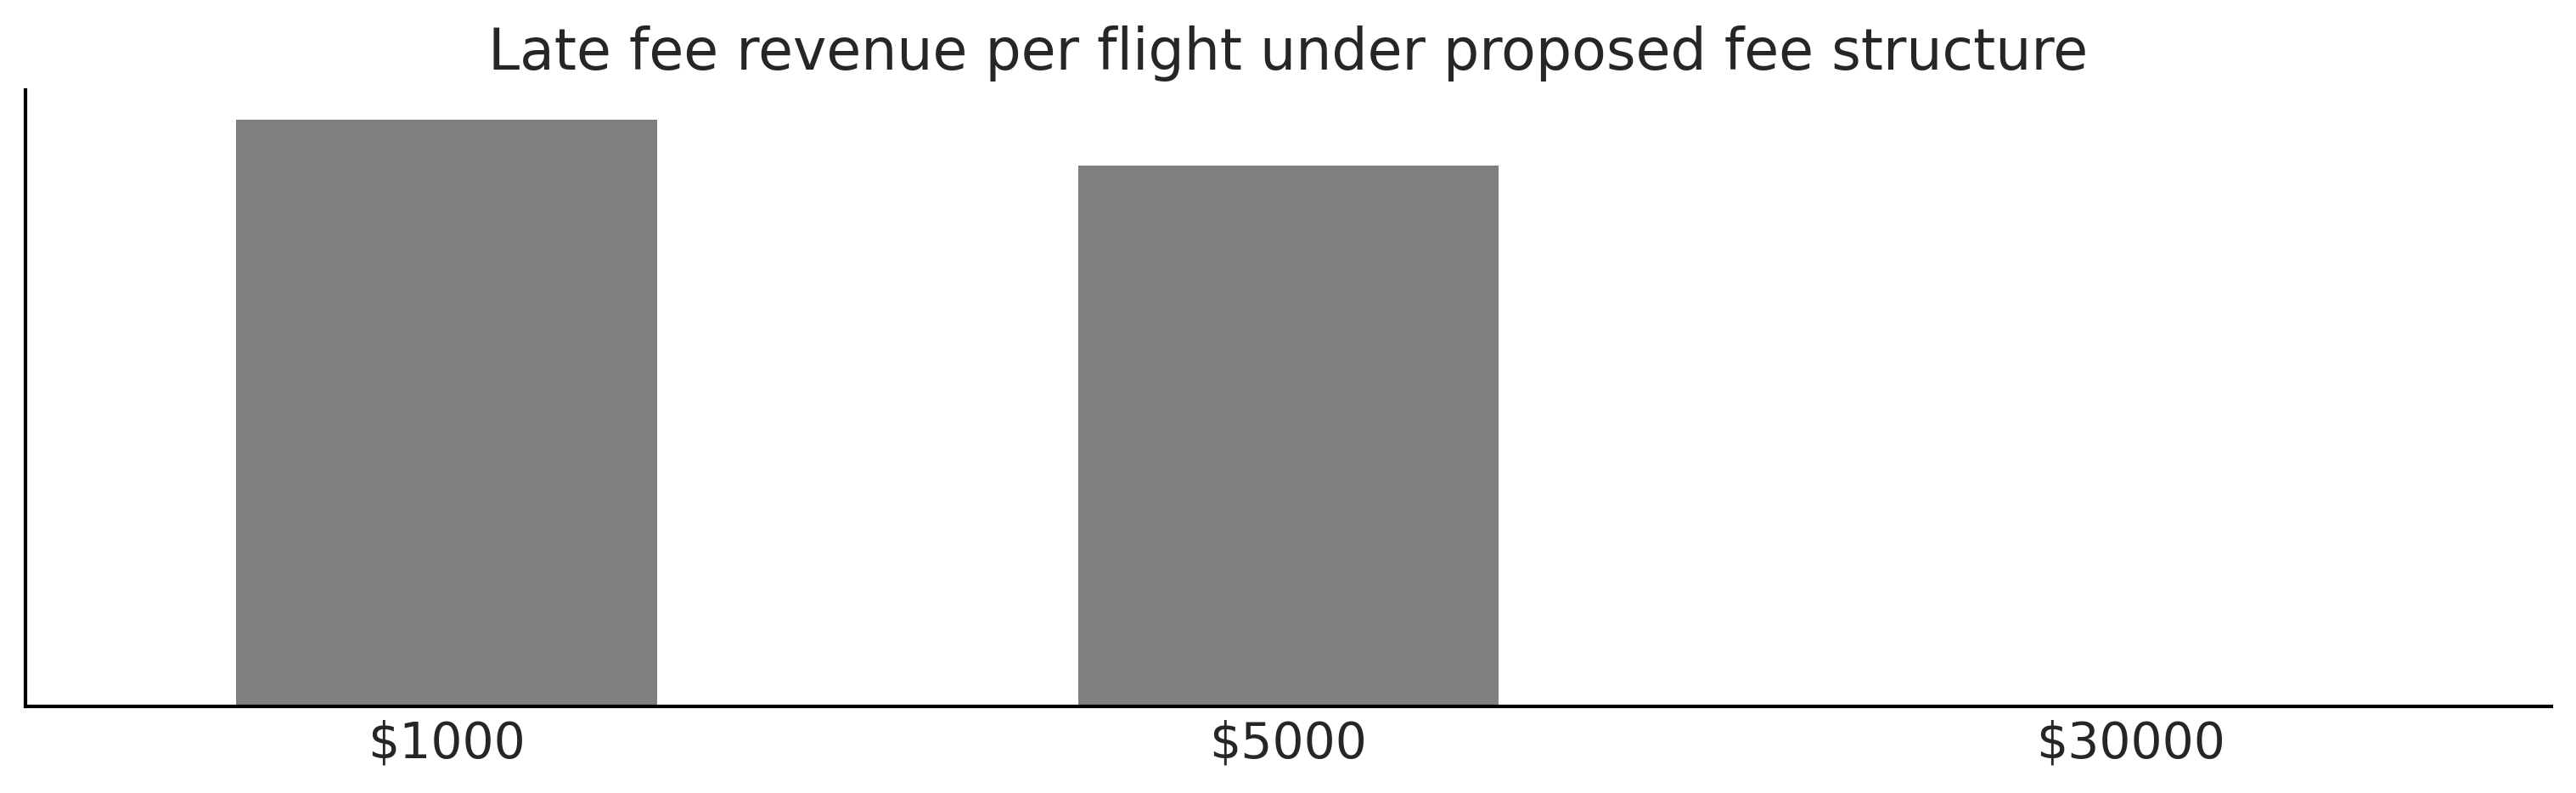

In [32]:
fig, ax = plt.subplots(figsize=(10, 3))

counts = pd.Series(revenue_per_flight_proposed.flatten()).value_counts()
counts.index = counts.index.astype(int)

counts.plot(kind="bar", ax=ax, color="C2")
ax.set_title("Late fee revenue per flight under proposed fee structure")
ax.set_yticks([]);
ax.tick_params(axis='x', labelrotation = 0)
ax.set_xticklabels([f"${i}" for i in counts.index])

plt.savefig("img/chp09/late_fee_proposed_structure_hist.png");

### Table 9.2

In [33]:
counts

1000     1107225
5000     1019804
30000        599
Name: count, dtype: int64

In [34]:
counts/counts.sum()*100

1000     52.040347
5000     47.931499
30000     0.028153
Name: count, dtype: float64

## Experimental Example: Comparing Between Two Groups

In [35]:
composites_df = pd.read_csv("../data/CompositeTensileTest.csv")

In [36]:
unidirectional = composites_df["Unidirectional Ultimate Strength (ksi)"].values
bidirectional = composites_df["Bidirectional Ultimate Strength (ksi)"].values

### Code 9.11

In [37]:
with pm.Model() as unidirectional_model:
    sd = pm.HalfStudentT("sd_uni", 20)
    mu = pm.Normal("mu_uni", 120, 30)
    
    uni_ksi = pm.Normal("uni_ksi", mu=mu, sigma=sd, observed=unidirectional)
    
    uni_data = pm.sample(draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_uni, mu_uni]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


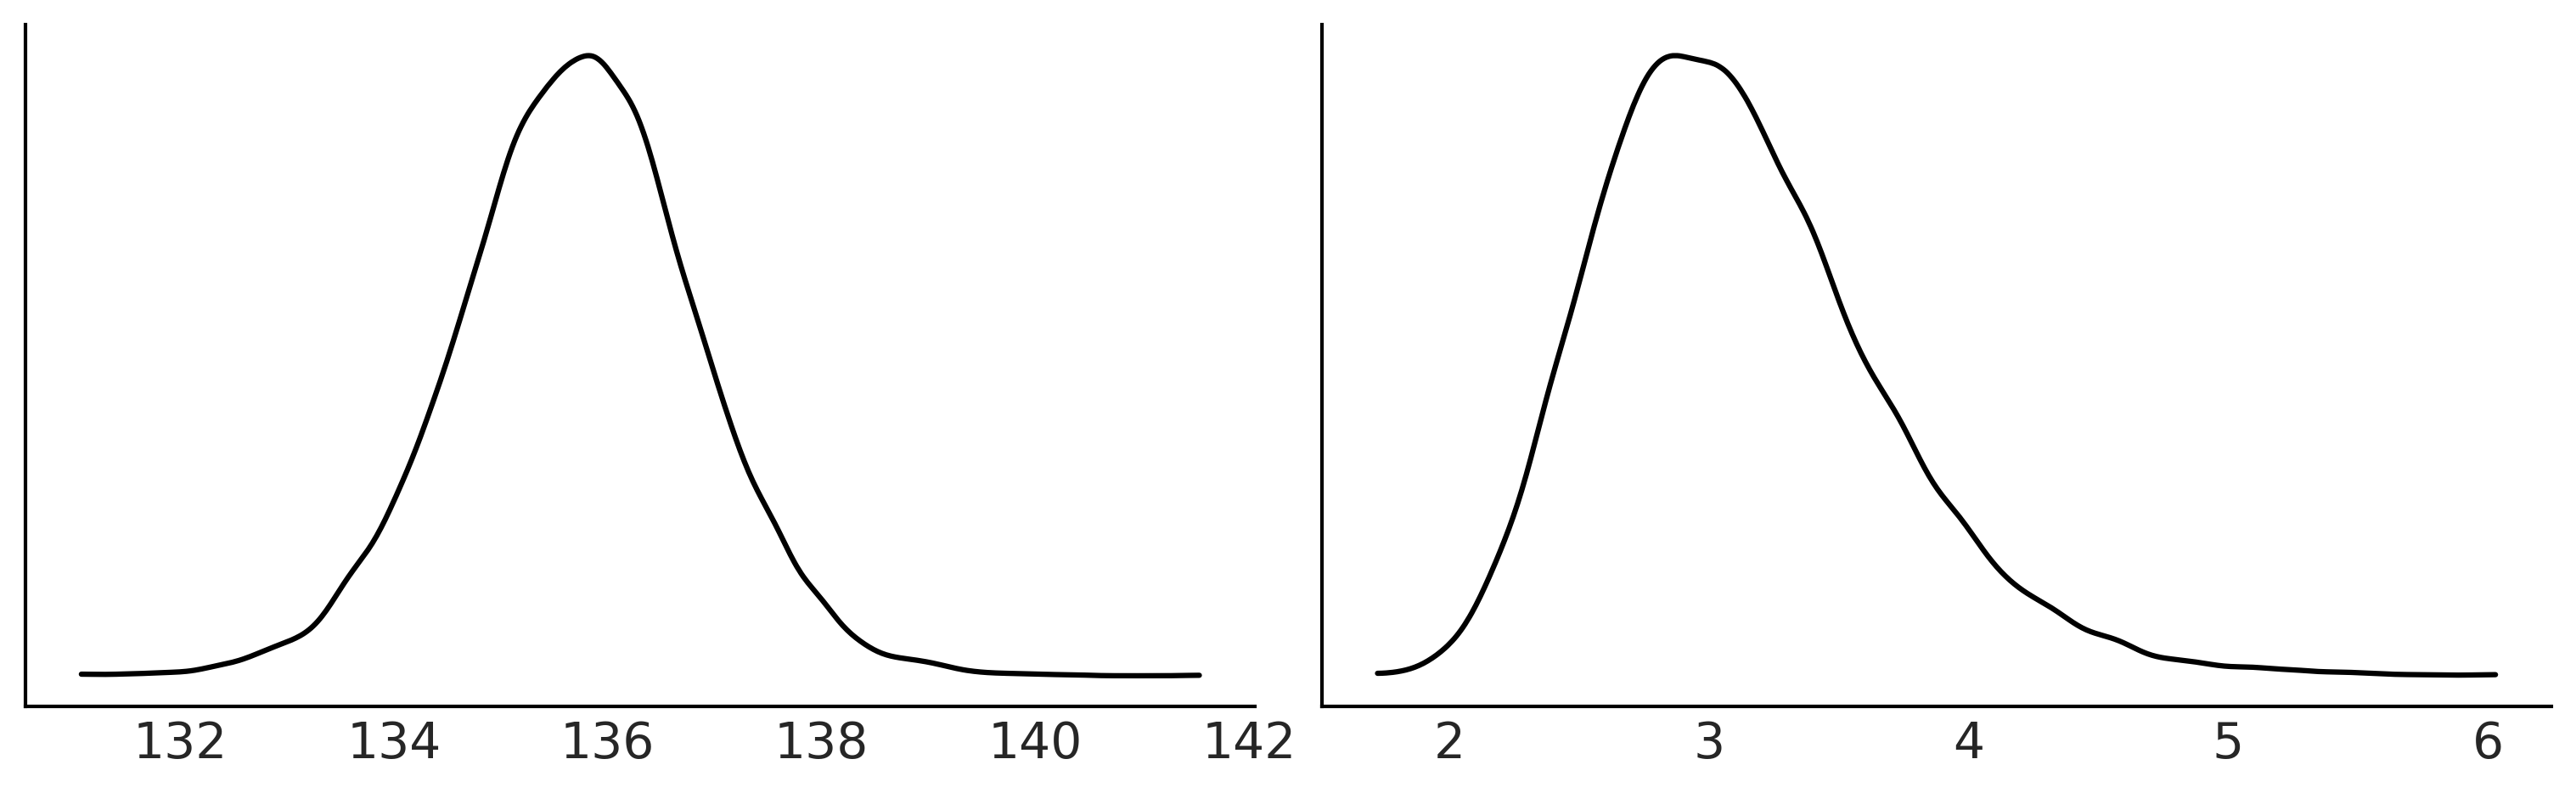

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
az.plot_dist(uni_data.posterior["mu_uni"], ax=axes[0]);
az.plot_dist(uni_data.posterior["sd_uni"], ax=axes[1]);
axes[0].set_yticks([])
axes[1].set_yticks([])
fig.savefig("img/chp09/kde_uni.png")

### Code 9.12 and Figure 9.15

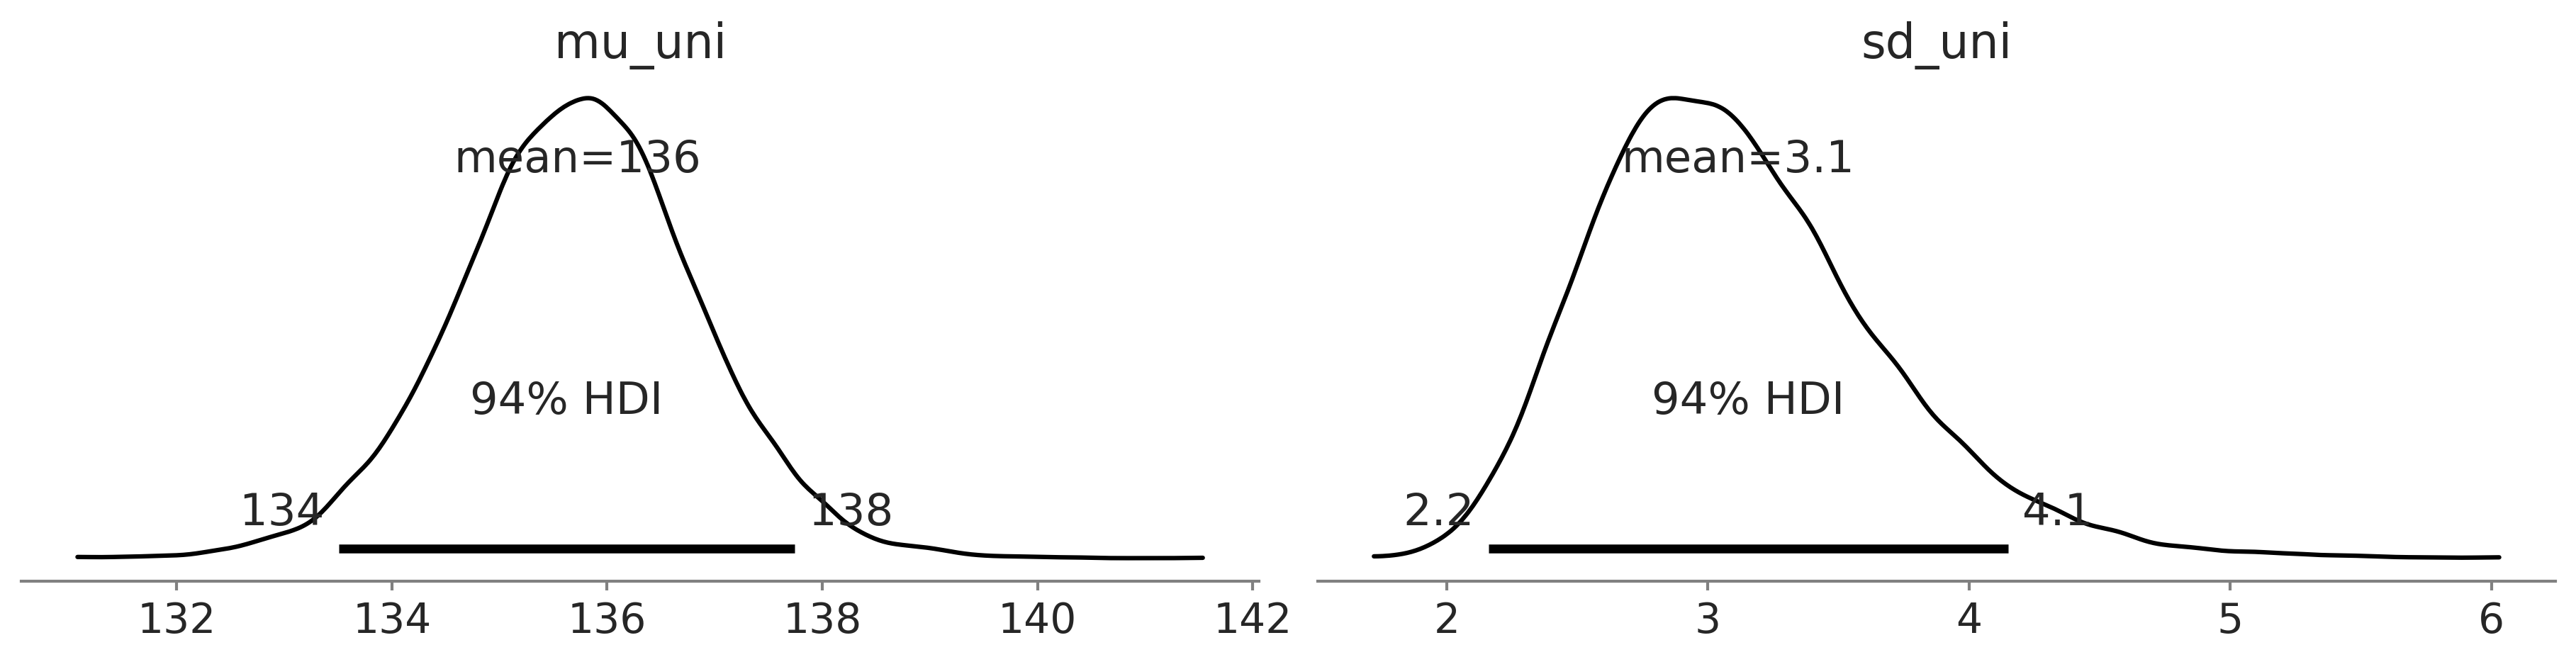

In [39]:
az.plot_posterior(uni_data, figsize=(12, 3));
plt.savefig("img/chp09/posterior_uni.png")

### Code 9.13

In [40]:
μ_m = 120
μ_s = 30

σ_low = 10
σ_high = 30

with pm.Model() as model:
    uni_mean = pm.Normal('uni_mean', mu=μ_m, sigma=μ_s)
    bi_mean = pm.Normal('bi_mean', mu=μ_m, sigma=μ_s)
    
    uni_std = pm.Uniform('uni_std', lower=σ_low, upper=σ_high)
    bi_std = pm.Uniform('bi_std', lower=σ_low, upper=σ_high)
    
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1
    
    λ1 = uni_std**-2
    λ2 = bi_std**-2

    group1 = pm.StudentT('uni', nu=ν, mu=uni_mean, lam=λ1, observed=unidirectional)
    group2 = pm.StudentT('bi', nu=ν, mu=bi_mean, lam=λ2, observed=bidirectional)
    
    diff_of_means = pm.Deterministic('Difference of Means', uni_mean - bi_mean)
    diff_of_stds = pm.Deterministic('Difference of Stds', uni_std - bi_std)
    effect_size = pm.Deterministic('Effect Size',
                                   diff_of_means / np.sqrt((uni_std**2 + bi_std**2) / 2))
    
    t_idata = pm.sample(draws=10000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [uni_mean, bi_mean, uni_std, bi_std, ν_minus_one]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 18 seconds.


### Code 9.14

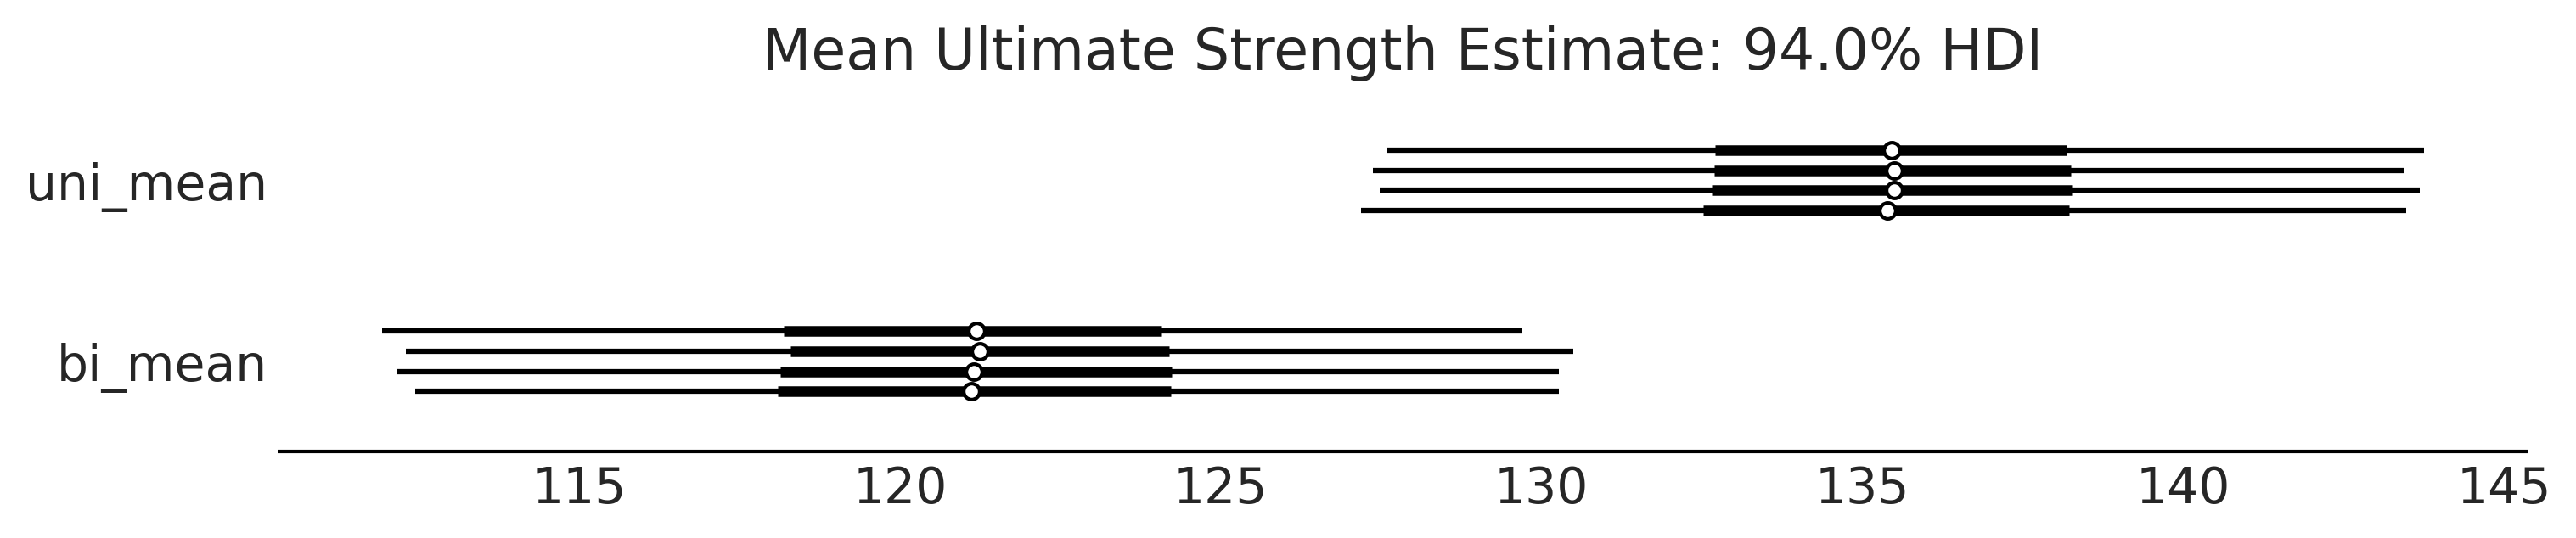

In [41]:
axes = az.plot_forest(t_idata, var_names=['uni_mean','bi_mean'], figsize=(10, 2));
axes[0].set_title("Mean Ultimate Strength Estimate: 94.0% HDI")
plt.savefig("img/chp09/Posterior_Forest_Plot.png")

### Code 9.15 and Figure 9.17

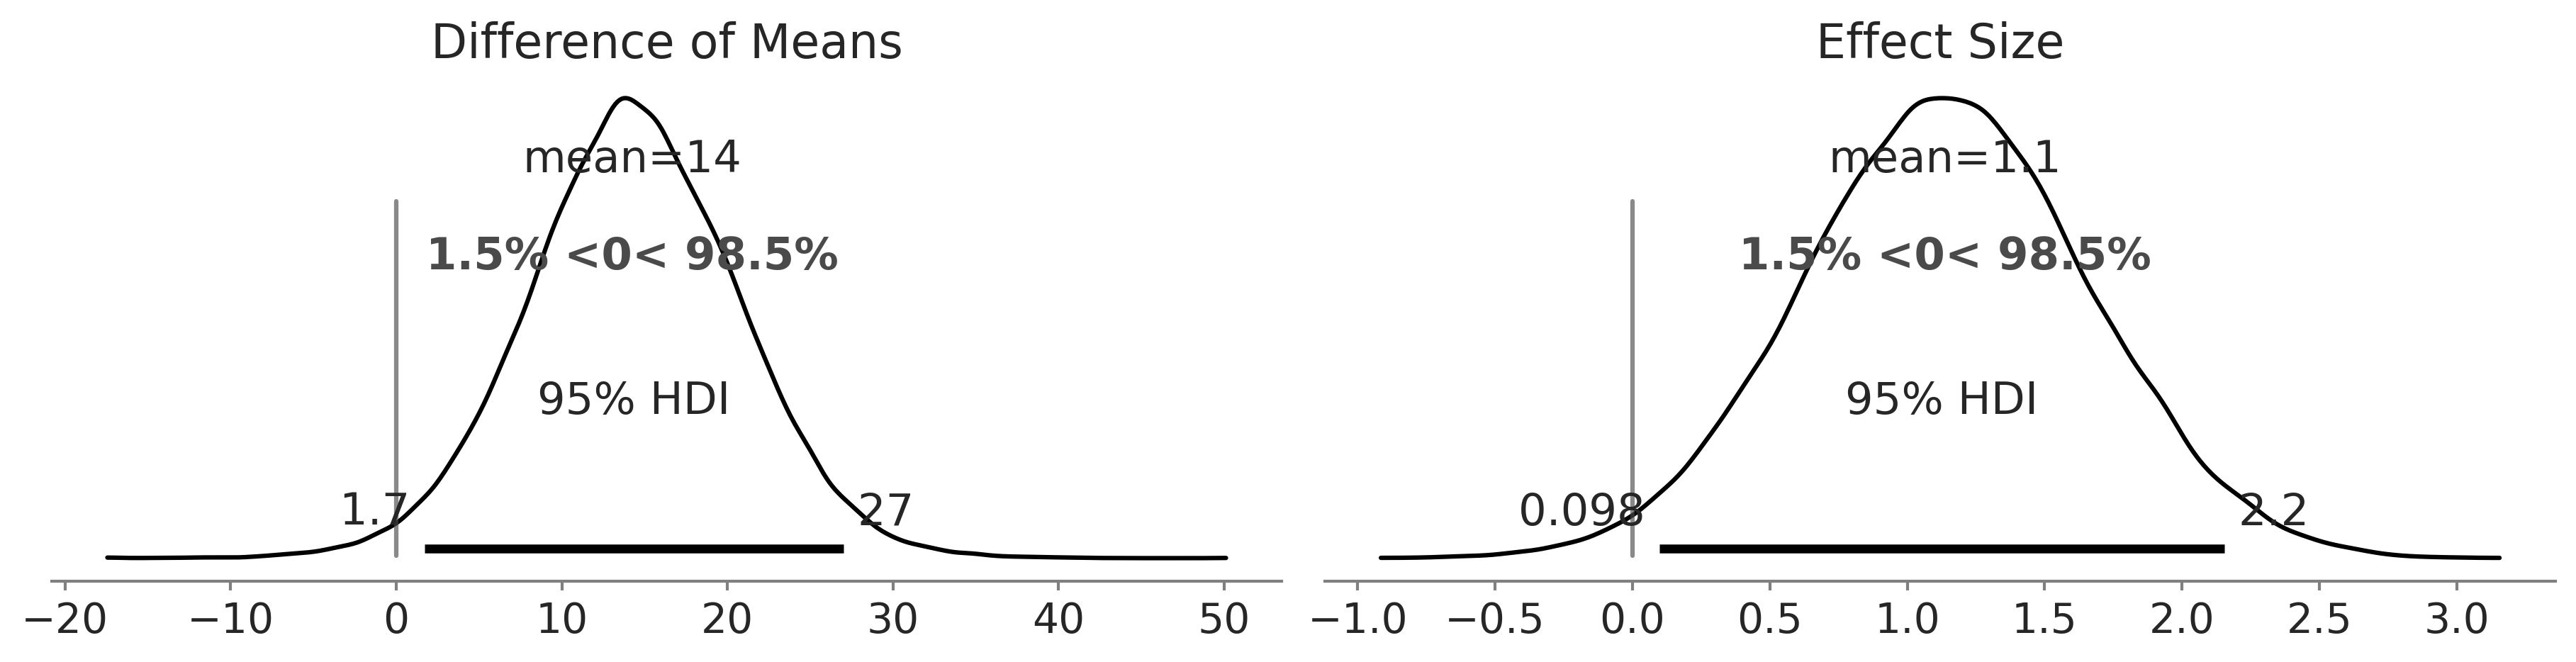

In [42]:
az.plot_posterior(t_idata, var_names=['Difference of Means','Effect Size'], hdi_prob=.95, ref_val=0, figsize=(12, 3));
plt.savefig("img/chp09/composite_difference_of_means.png")

### Code 9.16

In [43]:
az.summary(t_idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
uni_mean,135.427,4.324,127.554,143.759
bi_mean,121.164,4.769,112.175,130.207
uni_std,12.208,2.476,10.000,16.559
bi_std,13.223,3.201,10.000,19.198
ν_minus_one,36.469,30.519,0.607,91.564
Difference of Means,14.264,6.432,2.141,26.373
Difference of Stds,-1.016,4.041,-9.530,6.731
Effect Size,1.138,0.523,0.168,2.140
